# * Postpaid Performance

## Import Data Source

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [2]:
data_src = "../Raw-Agg Perf Nationwide_Wk 2023022.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD List '''
postpaid_rev_cd_list = ['B2R000100', 'B2R000101', 'B2R000102']
postpaid_dtac_rev_cd_list = ['DB2R000100', 'DB2R000101', 'DB2R000102']
postpaid_tmh_rev_cd_list = ['TB2R000100', 'TB2R000101', 'TB2R000102']
postpaid_all_rev_cd_list = postpaid_rev_cd_list + postpaid_dtac_rev_cd_list + postpaid_tmh_rev_cd_list
postpaid_total_rev_cd_list = ['B2R000100', 'DB2R000100', 'TB2R000100']

In [3]:
df.shape

(52400, 22)

In [4]:
# ''' Find Metric '''
# # df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
# df_metric = pd.concat([df_agg_s, df_agg_n])
# df_metric

# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="Postpaid"]#.reset_index()
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")].reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()

# # df_tmp.to_excel('Postpaid_Metric.xlsx', index=False)
# df_tmp

## Data Preporation

In [5]:
''' Rawdata '''

''' Function : Unit Million Baht '''
def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202305] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
df = df[df['TM_KEY_DAY'] <= 20230606] # DAY filter
df = df[df['METRIC_CD'].isin(postpaid_all_rev_cd_list)]#.reset_index()

''' Modify '''
df.loc[:, 'ACTUAL_SNAP'] = unit_mb(df['ACTUAL_SNAP'])
df.loc[:, 'ACTUAL_AGG'] = unit_mb(df['ACTUAL_AGG'])
df.loc[:, 'TARGET_SNAP'] = unit_mb(df['TARGET_SNAP'])
df.loc[:, 'TARGET_AGG'] = unit_mb(df['TARGET_AGG'])

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,UOM,PERIOD,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
23895,20230604,2023022,202306,20232,2023,Sales & Revenue,Revenue,TRUE,Postpaid,TB2R000100,...,baht,M,NaN,591.748031,NaN,614.794826,2023-06-09 17:51:25,June,22,4
23896,20230605,2023023,202306,20232,2023,Sales & Revenue,Revenue,TRUE,Postpaid,TB2R000100,...,baht,M,NaN,591.748031,NaN,614.794826,2023-06-09 17:51:25,June,23,5
23897,20230606,2023023,202306,20232,2023,Sales & Revenue,Revenue,TRUE,Postpaid,TB2R000100,...,baht,M,230.686062,822.434093,236.119197,850.914023,2023-06-09 17:51:25,June,23,6


In [6]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACTUAL_SNAP')

In [7]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_day = df['TM_KEY_DAY'].max()
last_ppn_tm = df['PPN_TM'].max()

### DAY : Aggregation (base level)

In [8]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG']
df_rev_day = df[cols_agg].reset_index()

''' Aggregation '''
df_rev_day['ACTUAL'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACTUAL_AGG'], df_rev_day['ACTUAL_SNAP'])
df_rev_day['TARGET'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TARGET_AGG'], df_rev_day['TARGET_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACTUAL'] / df_rev_day['TARGET']
df_rev_day['GAP'] = df_rev_day['ACTUAL'] - df_rev_day['TARGET']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACTUAL'].shift()
df_rev_day['DIFF'] = df_rev_day['ACTUAL'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACTUAL'] / df_rev_day['LAST_ACT']) - 1

# # df_rev_day.to_excel('df_rev_mth.xlsx')
df_rev_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,ACTUAL,TARGET,%ACHV,GAP,LAST_ACT,DIFF,%DOD
879,23895,TB2R000100,Postpaid Revenue : TMH,20230604,2023022,202306,20232,2023,June,4,...,591.748031,NaN,614.794826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880,23896,TB2R000100,Postpaid Revenue : TMH,20230605,2023023,202306,20232,2023,June,5,...,591.748031,NaN,614.794826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881,23897,TB2R000100,Postpaid Revenue : TMH,20230606,2023023,202306,20232,2023,June,6,...,822.434093,236.119197,850.914023,230.686062,236.119197,0.97699,-5.433135,NaN,NaN,NaN


In [9]:
''' Pivot by KPIS '''

''' Pivot Actual '''
pv_rev_day_act = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', values='ACTUAL_SNAP').reset_index()
pv_rev_day_act.rename(columns=({'Postpaid Existing Revenue': 'ACT_EXIST', 'Postpaid Existing Revenue : DTAC': 'ACT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'ACT_EXIST_TMH', 
                                'Postpaid New Revenue': 'ACT_NEW', 'Postpaid New Revenue : DTAC': 'ACT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'ACT_NEW_TMH', 
                                'Postpaid Revenue': 'ACT', 'Postpaid Revenue : DTAC': 'ACT_DTAC', 'Postpaid Revenue : TMH': 'ACT_TMH'}), inplace=True)
''' Pivot Target '''
pv_rev_day_tgt = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='TARGET_SNAP')
pv_rev_day_tgt.rename(columns=({'Postpaid Existing Revenue': 'TGT_EXIST', 'Postpaid Existing Revenue : DTAC': 'TGT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'TGT_EXIST_TMH', 
                                'Postpaid New Revenue': 'TGT_NEW', 'Postpaid New Revenue : DTAC': 'TGT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'TGT_NEW_TMH', 
                                'Postpaid Revenue': 'TGT', 'Postpaid Revenue : DTAC': 'TGT_DTAC', 'Postpaid Revenue : TMH': 'TGT_TMH'}), inplace=True)
''' Pivot %Achievement '''
pv_rev_day_achv = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='%ACHV')
pv_rev_day_achv.rename(columns=({'Postpaid Existing Revenue': '%ACHV_EXIST', 'Postpaid Existing Revenue : DTAC': '%ACHV_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': '%ACHV_EXIST_TMH', 
                                 'Postpaid New Revenue': '%ACHV_NEW', 'Postpaid New Revenue : DTAC': '%ACHV_NEW_DTAC', 'Postpaid New Revenue : TMH': '%ACHV_NEW_TMH', 
                                 'Postpaid Revenue': '%ACHV', 'Postpaid Revenue : DTAC': '%ACHV_DTAC', 'Postpaid Revenue : TMH': '%ACHV_TMH'}), inplace=True)
''' Pivot Gap '''
pv_rev_day_gap = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='GAP')
pv_rev_day_gap.rename(columns=({'Postpaid Existing Revenue': 'GAP_EXIST', 'Postpaid Existing Revenue : DTAC': 'GAP_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'GAP_EXIST_TMH', 
                                'Postpaid New Revenue': 'GAP_NEW', 'Postpaid New Revenue : DTAC': 'GAP_NEW_DTAC', 'Postpaid New Revenue : TMH': 'GAP_NEW_TMH', 
                                'Postpaid Revenue': 'GAP', 'Postpaid Revenue : DTAC': 'GAP_DTAC', 'Postpaid Revenue : TMH': 'GAP_TMH'}), inplace=True)
''' Pivot Last Actual '''
pv_rev_day_last_act = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='LAST_ACT')
pv_rev_day_last_act.rename(columns=({'Postpaid Existing Revenue': 'LAST_ACT_EXIST', 'Postpaid Existing Revenue : DTAC': 'LAST_ACT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'LAST_ACT_EXIST_TMH', 
                                     'Postpaid New Revenue': 'LAST_ACT_NEW', 'Postpaid New Revenue : DTAC': 'LAST_ACT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'LAST_ACT_NEW_TMH', 
                                     'Postpaid Revenue': 'LAST_ACT', 'Postpaid Revenue : DTAC': 'LAST_ACT_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_TMH'}), inplace=True)
''' Pivot Diff Last Actual '''
pv_rev_day_diff = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='DIFF')
pv_rev_day_diff.rename(columns=({'Postpaid Existing Revenue': 'DIFF_EXIST', 'Postpaid Existing Revenue : DTAC': 'DIFF_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'DIFF_EXIST_TMH', 
                                 'Postpaid New Revenue': 'DIFF_NEW', 'Postpaid New Revenue : DTAC': 'DIFF_NEW_DTAC', 'Postpaid New Revenue : TMH': 'DIFF_NEW_TMH', 
                                 'Postpaid Revenue': 'DIFF', 'Postpaid Revenue : DTAC': 'DIFF_DTAC', 'Postpaid Revenue : TMH': 'DIFF_TMH'}), inplace=True)
''' Pivot %DOD '''
pv_rev_day_dod = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='%DOD')
pv_rev_day_dod.rename(columns=({'Postpaid Existing Revenue': '%DOD_EXIST', 'Postpaid Existing Revenue : DTAC': '%DOD_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': '%DOD_EXIST_TMH', 
                                'Postpaid New Revenue': '%DOD_NEW', 'Postpaid New Revenue : DTAC': '%DOD_NEW_DTAC', 'Postpaid New Revenue : TMH': '%DOD_NEW_TMH', 
                                'Postpaid Revenue': '%DOD', 'Postpaid Revenue : DTAC': '%DOD_DTAC', 'Postpaid Revenue : TMH': '%DOD_TMH'}), inplace=True)

''' Merge all dataframe '''
all_pv_day = [pv_rev_day_act, pv_rev_day_tgt, pv_rev_day_achv, pv_rev_day_gap, pv_rev_day_last_act, pv_rev_day_diff, pv_rev_day_dod]
df_rev_day_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_DAY'), all_pv_day)
df_rev_day_agg.tail(3)

METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,ACT_EXIST,ACT_EXIST_DTAC,ACT_EXIST_TMH,...,DIFF_TMH,%DOD_EXIST,%DOD_EXIST_DTAC,%DOD_EXIST_TMH,%DOD_NEW,%DOD_NEW_DTAC,%DOD_NEW_TMH,%DOD,%DOD_DTAC,%DOD_TMH
95,20230604,2023022,202306,20232,2023,June,4,90.065989,90.065989,NaN,...,NaN,0.000559,0.000559,NaN,-0.040488,-0.040488,NaN,-0.002660,-0.002660,NaN
96,20230605,2023023,202306,20232,2023,June,5,86.859167,86.859167,NaN,...,NaN,-0.035605,-0.035605,NaN,-0.009851,-0.009851,NaN,-0.033662,-0.033662,NaN
97,20230606,2023023,202306,20232,2023,June,6,291.198349,93.062948,198.135401,...,NaN,2.352534,0.071423,NaN,4.488321,0.016267,NaN,2.517672,0.067159,NaN


## ** Yearly

### YR : Aggregation

In [10]:
''' Year to Date Values '''

df_last_yr = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT', 'TGT']].reset_index()
day_cnt_curr_yr = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_YR']==curr_yr) & (df_rev_day_agg['ACT']>0)]['TM_KEY_DAY'].unique())
ytd_last_act = (df_last_yr['ACT'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT'].sum()
ytd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TGT'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

/var/folders/4k/rll8vh6907l11_74m6bygwlc0000gn/T/ipykernel_3188/2710239038.py:5: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [11]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_rev_yr['%ACHV'] = df_rev_yr['ACTUAL_SNAP'] / df_rev_yr['TARGET_SNAP']
df_rev_yr['GAP'] = df_rev_yr['ACTUAL_SNAP'] - df_rev_yr['TARGET_SNAP']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACTUAL_SNAP'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACTUAL_SNAP'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACTUAL_SNAP'] / df_rev_yr['LAST_ACT']) - 1

# df_rev_yr.to_excel('df_rev_yr.xlsx')
df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACTUAL_SNAP,TARGET_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,B2R000100,Postpaid Revenue,2023,S,21310.674732,21489.287168,0.991688,-178.612436,NaN,NaN,NaN
1,B2R000101,Postpaid New Revenue,2023,S,1300.519981,0.000000,inf,1300.519981,NaN,NaN,NaN
2,B2R000102,Postpaid Existing Revenue,2023,S,20010.154751,0.000000,inf,20010.154751,NaN,NaN,NaN
3,DB2R000100,Postpaid Revenue : DTAC,2023,S,9545.547192,9712.523155,0.982808,-166.975963,NaN,NaN,NaN
4,DB2R000101,Postpaid New Revenue : DTAC,2023,S,562.832510,0.000000,inf,562.832510,NaN,NaN,NaN
5,DB2R000102,Postpaid Existing Revenue : DTAC,2023,S,8982.714682,0.000000,inf,8982.714682,NaN,NaN,NaN
6,TB2R000100,Postpaid Revenue : TMH,2023,S,11765.127540,11776.764013,0.999012,-11.636473,NaN,NaN,NaN
7,TB2R000101,Postpaid New Revenue : TMH,2023,S,737.687472,954.258682,0.773048,-216.571210,NaN,NaN,NaN
8,TB2R000102,Postpaid Existing Revenue : TMH,2023,S,11027.440069,10775.823383,1.023350,251.616686,NaN,NaN,NaN


In [12]:
''' Pivot by KPIS '''

''' Pivot Actual '''
pv_rev_yr_act = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='ACTUAL_SNAP').reset_index()
pv_rev_yr_act.rename(columns=({'Postpaid Existing Revenue': 'ACT_EXIST', 'Postpaid Existing Revenue : DTAC': 'ACT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'ACT_EXIST_TMH', 
                               'Postpaid New Revenue': 'ACT_NEW', 'Postpaid New Revenue : DTAC': 'ACT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'ACT_NEW_TMH', 
                               'Postpaid Revenue': 'ACT', 'Postpaid Revenue : DTAC': 'ACT_DTAC', 'Postpaid Revenue : TMH': 'ACT_TMH'}), inplace=True)
''' Pivot Target '''
pv_rev_yr_tgt = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='TARGET_SNAP')
pv_rev_yr_tgt.rename(columns=({'Postpaid Existing Revenue': 'TGT_EXIST', 'Postpaid Existing Revenue : DTAC': 'TGT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'TGT_EXIST_TMH', 
                               'Postpaid New Revenue': 'TGT_NEW', 'Postpaid New Revenue : DTAC': 'TGT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'TGT_NEW_TMH', 
                               'Postpaid Revenue': 'TGT', 'Postpaid Revenue : DTAC': 'TGT_DTAC', 'Postpaid Revenue : TMH': 'TGT_TMH'}), inplace=True)
''' Pivot %Achievement '''
pv_rev_yr_achv = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='%ACHV')
pv_rev_yr_achv.rename(columns=({'Postpaid Existing Revenue': '%ACHV_EXIST', 'Postpaid Existing Revenue : DTAC': '%ACHV_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': '%ACHV_EXIST_TMH', 
                                'Postpaid New Revenue': '%ACHV_NEW', 'Postpaid New Revenue : DTAC': '%ACHV_NEW_DTAC', 'Postpaid New Revenue : TMH': '%ACHV_NEW_TMH', 
                                'Postpaid Revenue': '%ACHV', 'Postpaid Revenue : DTAC': '%ACHV_DTAC', 'Postpaid Revenue : TMH': '%ACHV_TMH'}), inplace=True)
''' Pivot Gap '''
pv_rev_yr_gap = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='GAP')
pv_rev_yr_gap.rename(columns=({'Postpaid Existing Revenue': 'GAP_EXIST', 'Postpaid Existing Revenue : DTAC': 'GAP_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'GAP_EXIST_TMH', 
                               'Postpaid New Revenue': 'GAP_NEW', 'Postpaid New Revenue : DTAC': 'GAP_NEW_DTAC', 'Postpaid New Revenue : TMH': 'GAP_NEW_TMH', 
                               'Postpaid Revenue': 'GAP', 'Postpaid Revenue : DTAC': 'GAP_DTAC', 'Postpaid Revenue : TMH': 'GAP_TMH'}), inplace=True)
''' Pivot Last Actual '''
pv_rev_yr_last_act = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='LAST_ACT')
pv_rev_yr_last_act.rename(columns=({'Postpaid Existing Revenue': 'LAST_ACT_EXIST', 'Postpaid Existing Revenue : DTAC': 'LAST_ACT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'LAST_ACT_EXIST_TMH', 
                                    'Postpaid New Revenue': 'LAST_ACT_NEW', 'Postpaid New Revenue : DTAC': 'LAST_ACT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'LAST_ACT_NEW_TMH', 
                                    'Postpaid Revenue': 'LAST_ACT', 'Postpaid Revenue : DTAC': 'LAST_ACT_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_TMH'}), inplace=True)
''' Pivot Diff Last Actual '''
pv_rev_yr_diff = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='DIFF')
pv_rev_yr_diff.rename(columns=({'Postpaid Existing Revenue': 'DIFF_EXIST', 'Postpaid Existing Revenue : DTAC': 'DIFF_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'DIFF_EXIST_TMH', 
                                'Postpaid New Revenue': 'DIFF_NEW', 'Postpaid New Revenue : DTAC': 'DIFF_NEW_DTAC', 'Postpaid New Revenue : TMH': 'DIFF_NEW_TMH', 
                                'Postpaid Revenue': 'DIFF', 'Postpaid Revenue : DTAC': 'DIFF_DTAC', 'Postpaid Revenue : TMH': 'DIFF_TMH'}), inplace=True)
''' Pivot %YOY '''
pv_rev_yr_yoy = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='%YOY')
pv_rev_yr_yoy.rename(columns=({'Postpaid Existing Revenue': '%YOY_EXIST', 'Postpaid Existing Revenue : DTAC': '%YOY_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': '%YOY_EXIST_TMH', 
                               'Postpaid New Revenue': '%YOY_NEW', 'Postpaid New Revenue : DTAC': '%YOY_NEW_DTAC', 'Postpaid New Revenue : TMH': '%YOY_NEW_TMH', 
                               'Postpaid Revenue': '%YOY', 'Postpaid Revenue : DTAC': '%YOY_DTAC', 'Postpaid Revenue : TMH': '%YOY_TMH'}), inplace=True)

''' Merge all dataframe '''
all_pv_yr = [pv_rev_yr_act, pv_rev_yr_tgt, pv_rev_yr_achv, pv_rev_yr_gap, pv_rev_yr_last_act, pv_rev_yr_diff, pv_rev_yr_yoy]
df_rev_yr_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_YR'), all_pv_yr)
df_rev_yr_agg.tail(3)

METRIC_NAME,TM_KEY_YR,ACT_EXIST,ACT_EXIST_DTAC,ACT_EXIST_TMH,ACT_NEW,ACT_NEW_DTAC,ACT_NEW_TMH,ACT,ACT_DTAC,ACT_TMH,...,DIFF_TMH,%YOY_EXIST,%YOY_EXIST_DTAC,%YOY_EXIST_TMH,%YOY_NEW,%YOY_NEW_DTAC,%YOY_NEW_TMH,%YOY,%YOY_DTAC,%YOY_TMH
0,2023,20010.154751,8982.714682,11027.440069,1300.519981,562.83251,737.687472,21310.674732,9545.547192,11765.12754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Values '''
y_yr_act = df_rev_yr_agg['ACT']
y_yr_act_dtac = df_rev_yr_agg['ACT_DTAC']
y_yr_act_tmh = df_rev_yr_agg['ACT_TMH']
y_yr_tgt = df_rev_yr_agg['TGT']
y_yr_tgt_dtac = df_rev_yr_agg['TGT_DTAC']
y_yr_tgt_tmh = df_rev_yr_agg['TGT_TMH']
y_yr_achv = df_rev_yr_agg['%ACHV']
y_yr_achv_dtac = df_rev_yr_agg['%ACHV_DTAC']
y_yr_achv_tmh = df_rev_yr_agg['%ACHV_TMH']
y_yr_gap = df_rev_yr_agg['GAP']
y_yr_gap_dtac = df_rev_yr_agg['GAP_DTAC']
y_yr_gap_tmh = df_rev_yr_agg['GAP_TMH']
y_yr_diff = df_rev_yr_agg['DIFF']
y_yr_diff_dtac = df_rev_yr_agg['DIFF_DTAC']
y_yr_diff_tmh = df_rev_yr_agg['DIFF_TMH']
y_yr_last_act = df_rev_yr_agg['LAST_ACT']
y_yr_last_act_dtac = df_rev_yr_agg['LAST_ACT_DTAC']
y_yr_last_act_tmh = df_rev_yr_agg['LAST_ACT_TMH']
y_yr_yoy = df_rev_yr_agg['%YOY']
y_yr_yoy_dtac = df_rev_yr_agg['%YOY_DTAC']
y_yr_yoy_tmh = df_rev_yr_agg['%YOY_TMH']

''' NEW : Values '''
y_yr_act_new = df_rev_yr_agg['ACT_NEW']
y_yr_act_new_dtac = df_rev_yr_agg['ACT_NEW_DTAC']
y_yr_act_new_tmh = df_rev_yr_agg['ACT_NEW_TMH']
y_yr_tgt_new = df_rev_yr_agg['TGT_NEW']
y_yr_tgt_new_dtac = df_rev_yr_agg['TGT_NEW_DTAC']
y_yr_tgt_new_tmh = df_rev_yr_agg['TGT_NEW_TMH']
y_yr_achv_new = df_rev_yr_agg['%ACHV_NEW']
y_yr_achv_new_dtac = df_rev_yr_agg['%ACHV_NEW_DTAC']
y_yr_achv_new_tmh = df_rev_yr_agg['%ACHV_NEW_TMH']
y_yr_gap_new = df_rev_yr_agg['GAP_NEW']
y_yr_gap_new_dtac = df_rev_yr_agg['GAP_NEW_DTAC']
y_yr_gap_new_tmh = df_rev_yr_agg['GAP_NEW_TMH']
y_yr_diff_new = df_rev_yr_agg['DIFF_NEW']
y_yr_diff_new_dtac = df_rev_yr_agg['DIFF_NEW_DTAC']
y_yr_diff_new_tmh = df_rev_yr_agg['DIFF_NEW_TMH']
y_yr_last_act_new = df_rev_yr_agg['LAST_ACT_NEW']
y_yr_last_act_new_dtac = df_rev_yr_agg['LAST_ACT_NEW_DTAC']
y_yr_last_act_new_tmh = df_rev_yr_agg['LAST_ACT_NEW_TMH']
y_yr_yoy_new = df_rev_yr_agg['%YOY_NEW']
y_yr_yoy_new_dtac = df_rev_yr_agg['%YOY_NEW_DTAC']
y_yr_yoy_new_tmh = df_rev_yr_agg['%YOY_NEW_TMH']

''' EXIST : Values '''
y_yr_act_exist = df_rev_yr_agg['ACT_EXIST']
y_yr_act_exist_dtac = df_rev_yr_agg['ACT_EXIST_DTAC']
y_yr_act_exist_tmh = df_rev_yr_agg['ACT_EXIST_TMH']
y_yr_tgt_exist = df_rev_yr_agg['TGT_EXIST']
y_yr_tgt_exist_dtac = df_rev_yr_agg['TGT_EXIST_DTAC']
y_yr_tgt_exist_tmh = df_rev_yr_agg['TGT_EXIST_TMH']
y_yr_achv_exist = df_rev_yr_agg['%ACHV_EXIST']
y_yr_achv_exist_dtac = df_rev_yr_agg['%ACHV_EXIST_DTAC']
y_yr_achv_exist_tmh = df_rev_yr_agg['%ACHV_EXIST_TMH']
y_yr_gap_exist = df_rev_yr_agg['GAP_EXIST']
y_yr_gap_exist_dtac = df_rev_yr_agg['GAP_EXIST_DTAC']
y_yr_gap_exist_tmh = df_rev_yr_agg['GAP_EXIST_TMH']
y_yr_diff_exist = df_rev_yr_agg['DIFF_EXIST']
y_yr_diff_exist_dtac = df_rev_yr_agg['DIFF_EXIST_DTAC']
y_yr_diff_exist_tmh = df_rev_yr_agg['DIFF_EXIST_TMH']
y_yr_last_act_exist = df_rev_yr_agg['LAST_ACT_EXIST']
y_yr_last_act_exist_dtac = df_rev_yr_agg['LAST_ACT_EXIST_DTAC']
y_yr_last_act_exist_tmh = df_rev_yr_agg['LAST_ACT_EXIST_TMH']
y_yr_yoy_exist = df_rev_yr_agg['%YOY_EXIST']
y_yr_yoy_exist_dtac = df_rev_yr_agg['%YOY_EXIST_DTAC']
y_yr_yoy_exist_tmh = df_rev_yr_agg['%YOY_EXIST_TMH']

### YR : Postpaid Revenue Summary

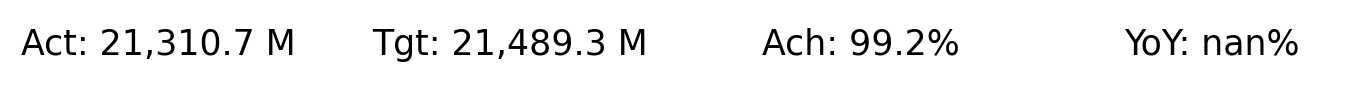

In [14]:
''' Yearly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(ytd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(ytd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

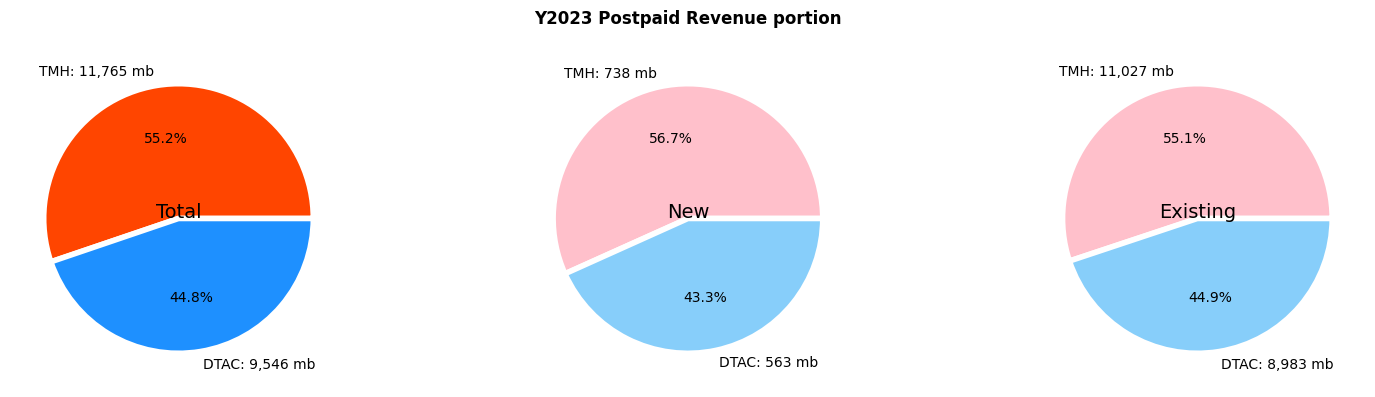

In [15]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(16, 4))
fig.suptitle(f'Y{curr_yr} Postpaid Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([y_yr_act_tmh.sum(), y_yr_act_dtac.sum()])
mylabels = [f"TMH: {format(y[0],',.0f')} mb", f"DTAC: {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.text(0, 0, 'Total', ha='center', fontsize=14)

''' ax2 '''
y = np.array([y_yr_act_new_tmh.sum(), y_yr_act_new_dtac.sum()])
mylabels = [f"TMH: {format(y[0],',.0f')} mb", f"DTAC: {format(y[1],',.0f')} mb"]
mycolors = ["pink", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'New', ha='center', fontsize=14)

''' ax3 '''
y = np.array([y_yr_act_exist_tmh.sum(), y_yr_act_exist_dtac.sum()])
mylabels = [f"TMH: {format(y[0],',.0f')} mb", f"DTAC: {format(y[1],',.0f')} mb"]
mycolors = ["pink", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Existing', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly

### MTH : Aggregation

In [16]:
''' Month to Date Values '''

df_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT', 'TGT']].reset_index()
day_cnt_curr_mth = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==curr_mth) & (df_rev_day_agg['ACT']>0)]['TM_KEY_DAY'].unique())
mtd_last_act = (df_last_mth['ACT'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT'].sum()
mtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

In [17]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = df_rev_mth['ACTUAL_SNAP'] / df_rev_mth['TARGET_SNAP']
df_rev_mth['GAP'] = df_rev_mth['ACTUAL_SNAP'] - df_rev_mth['TARGET_SNAP']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACTUAL_SNAP'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACTUAL_SNAP'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACTUAL_SNAP'] / df_rev_mth['LAST_ACT']) - 1

# df_rev_mth.to_excel('df_rev_mth.xlsx')
df_rev_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACTUAL_SNAP,TARGET_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%MOM
31,TB2R000101,Postpaid New Revenue : TMH,202306,June,S,81.671582,53.236824,1.534118,28.434758,282.288511,-200.616929,-0.710680
32,TB2R000102,Postpaid Existing Revenue : TMH,202303,March,S,3465.200316,3420.814115,1.012975,44.386201,NaN,NaN,NaN
33,TB2R000102,Postpaid Existing Revenue : TMH,202304,April,S,3473.884688,3338.722898,1.040483,135.161790,3465.200316,8.684372,0.002506
34,TB2R000102,Postpaid Existing Revenue : TMH,202305,May,S,3347.592554,3265.291120,1.025205,82.301434,3473.884688,-126.292134,-0.036355
35,TB2R000102,Postpaid Existing Revenue : TMH,202306,June,S,740.762511,750.995250,0.986374,-10.232739,3347.592554,-2606.830042,-0.778718


In [18]:
''' Pivot by KPIS '''

''' Pivot Actual '''
pv_rev_mth_act = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', values='ACTUAL_SNAP').reset_index()
pv_rev_mth_act.rename(columns=({'Postpaid Existing Revenue': 'ACT_EXIST', 'Postpaid Existing Revenue : DTAC': 'ACT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'ACT_EXIST_TMH', 
                               'Postpaid New Revenue': 'ACT_NEW', 'Postpaid New Revenue : DTAC': 'ACT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'ACT_NEW_TMH', 
                               'Postpaid Revenue': 'ACT', 'Postpaid Revenue : DTAC': 'ACT_DTAC', 'Postpaid Revenue : TMH': 'ACT_TMH'}), inplace=True)
''' Pivot Target '''
pv_rev_mth_tgt = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='TARGET_SNAP')
pv_rev_mth_tgt.rename(columns=({'Postpaid Existing Revenue': 'TGT_EXIST', 'Postpaid Existing Revenue : DTAC': 'TGT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'TGT_EXIST_TMH', 
                               'Postpaid New Revenue': 'TGT_NEW', 'Postpaid New Revenue : DTAC': 'TGT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'TGT_NEW_TMH', 
                               'Postpaid Revenue': 'TGT', 'Postpaid Revenue : DTAC': 'TGT_DTAC', 'Postpaid Revenue : TMH': 'TGT_TMH'}), inplace=True)
''' Pivot %Achievement '''
pv_rev_mth_achv = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='%ACHV')
pv_rev_mth_achv.rename(columns=({'Postpaid Existing Revenue': '%ACHV_EXIST', 'Postpaid Existing Revenue : DTAC': '%ACHV_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': '%ACHV_EXIST_TMH', 
                                'Postpaid New Revenue': '%ACHV_NEW', 'Postpaid New Revenue : DTAC': '%ACHV_NEW_DTAC', 'Postpaid New Revenue : TMH': '%ACHV_NEW_TMH', 
                                'Postpaid Revenue': '%ACHV', 'Postpaid Revenue : DTAC': '%ACHV_DTAC', 'Postpaid Revenue : TMH': '%ACHV_TMH'}), inplace=True)
''' Pivot Gap '''
pv_rev_mth_gap = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='GAP')
pv_rev_mth_gap.rename(columns=({'Postpaid Existing Revenue': 'GAP_EXIST', 'Postpaid Existing Revenue : DTAC': 'GAP_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'GAP_EXIST_TMH', 
                               'Postpaid New Revenue': 'GAP_NEW', 'Postpaid New Revenue : DTAC': 'GAP_NEW_DTAC', 'Postpaid New Revenue : TMH': 'GAP_NEW_TMH', 
                               'Postpaid Revenue': 'GAP', 'Postpaid Revenue : DTAC': 'GAP_DTAC', 'Postpaid Revenue : TMH': 'GAP_TMH'}), inplace=True)
''' Pivot Last Actual '''
pv_rev_mth_last_act = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='LAST_ACT')
pv_rev_mth_last_act.rename(columns=({'Postpaid Existing Revenue': 'LAST_ACT_EXIST', 'Postpaid Existing Revenue : DTAC': 'LAST_ACT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'LAST_ACT_EXIST_TMH', 
                                    'Postpaid New Revenue': 'LAST_ACT_NEW', 'Postpaid New Revenue : DTAC': 'LAST_ACT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'LAST_ACT_NEW_TMH', 
                                    'Postpaid Revenue': 'LAST_ACT', 'Postpaid Revenue : DTAC': 'LAST_ACT_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_TMH'}), inplace=True)
''' Pivot Diff Last Actual '''
pv_rev_mth_diff = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='DIFF')
pv_rev_mth_diff.rename(columns=({'Postpaid Existing Revenue': 'DIFF_EXIST', 'Postpaid Existing Revenue : DTAC': 'DIFF_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'DIFF_EXIST_TMH', 
                                'Postpaid New Revenue': 'DIFF_NEW', 'Postpaid New Revenue : DTAC': 'DIFF_NEW_DTAC', 'Postpaid New Revenue : TMH': 'DIFF_NEW_TMH', 
                                'Postpaid Revenue': 'DIFF', 'Postpaid Revenue : DTAC': 'DIFF_DTAC', 'Postpaid Revenue : TMH': 'DIFF_TMH'}), inplace=True)
''' Pivot %MOM '''
pv_rev_mth_mom = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='%MOM')
pv_rev_mth_mom.rename(columns=({'Postpaid Existing Revenue': '%MOM_EXIST', 'Postpaid Existing Revenue : DTAC': '%MOM_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': '%MOM_EXIST_TMH', 
                               'Postpaid New Revenue': '%MOM_NEW', 'Postpaid New Revenue : DTAC': '%MOM_NEW_DTAC', 'Postpaid New Revenue : TMH': '%MOM_NEW_TMH', 
                               'Postpaid Revenue': '%MOM', 'Postpaid Revenue : DTAC': '%MOM_DTAC', 'Postpaid Revenue : TMH': '%MOM_TMH'}), inplace=True)

''' Merge all dataframe '''
all_pv_mth = [pv_rev_mth_act, pv_rev_mth_tgt, pv_rev_mth_achv, pv_rev_mth_gap, pv_rev_mth_last_act, pv_rev_mth_diff, pv_rev_mth_mom]
df_rev_mth_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_MTH'), all_pv_mth)
df_rev_mth_agg.tail(3)

METRIC_NAME,TM_KEY_MTH,MTH_DESC,ACT_EXIST,ACT_EXIST_DTAC,ACT_EXIST_TMH,ACT_NEW,ACT_NEW_DTAC,ACT_NEW_TMH,ACT,ACT_DTAC,...,DIFF_TMH,%MOM_EXIST,%MOM_EXIST_DTAC,%MOM_EXIST_TMH,%MOM_NEW,%MOM_NEW_DTAC,%MOM_NEW_TMH,%MOM,%MOM_DTAC,%MOM_TMH
1,202304,April,6270.848061,2796.963373,3473.884688,383.266426,163.591058,219.675367,6654.114487,2960.554432,...,74.307727,-0.004140,-0.012274,0.002506,0.251598,0.075056,0.425982,0.007720,-0.007820,0.020531
2,202305,May,6102.837490,2755.244936,3347.592554,480.112803,197.824293,282.288511,6582.950294,2953.069229,...,-63.678991,-0.026792,-0.014916,-0.036355,0.252687,0.209261,0.285026,-0.010695,-0.002528,-0.017241
3,202306,June,1339.550181,598.787669,740.762511,130.918975,49.247393,81.671582,1470.469156,648.035063,...,-2807.446971,-0.780504,-0.782674,-0.778718,-0.727316,-0.751055,-0.710680,-0.776625,-0.780555,-0.773427


In [19]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Values '''
y_mth_act = df_rev_mth_agg['ACT']
y_mth_act_dtac = df_rev_mth_agg['ACT_DTAC']
y_mth_act_tmh = df_rev_mth_agg['ACT_TMH']
y_mth_tgt = df_rev_mth_agg['TGT']
y_mth_tgt_dtac = df_rev_mth_agg['TGT_DTAC']
y_mth_tgt_tmh = df_rev_mth_agg['TGT_TMH']
y_mth_achv = df_rev_mth_agg['%ACHV']
y_mth_achv_dtac = df_rev_mth_agg['%ACHV_DTAC']
y_mth_achv_tmh = df_rev_mth_agg['%ACHV_TMH']
y_mth_gap = df_rev_mth_agg['GAP']
y_mth_gap_dtac = df_rev_mth_agg['GAP_DTAC']
y_mth_gap_tmh = df_rev_mth_agg['GAP_TMH']
y_mth_diff = df_rev_mth_agg['DIFF']
y_mth_diff_dtac = df_rev_mth_agg['DIFF_DTAC']
y_mth_diff_tmh = df_rev_mth_agg['DIFF_TMH']
y_mth_last_act = df_rev_mth_agg['LAST_ACT']
y_mth_last_act_dtac = df_rev_mth_agg['LAST_ACT_DTAC']
y_mth_last_act_tmh = df_rev_mth_agg['LAST_ACT_TMH']
y_mth_mom = df_rev_mth_agg['%MOM']
y_mth_mom_dtac = df_rev_mth_agg['%MOM_DTAC']
y_mth_mom_tmh = df_rev_mth_agg['%MOM_TMH']

''' NEW : Values '''
y_mth_act_new = df_rev_mth_agg['ACT_NEW']
y_mth_act_new_dtac = df_rev_mth_agg['ACT_NEW_DTAC']
y_mth_act_new_tmh = df_rev_mth_agg['ACT_NEW_TMH']
y_mth_tgt_new = df_rev_mth_agg['TGT_NEW']
y_mth_tgt_new_dtac = df_rev_mth_agg['TGT_NEW_DTAC']
y_mth_tgt_new_tmh = df_rev_mth_agg['TGT_NEW_TMH']
y_mth_achv_new = df_rev_mth_agg['%ACHV_NEW']
y_mth_achv_new_dtac = df_rev_mth_agg['%ACHV_NEW_DTAC']
y_mth_achv_new_tmh = df_rev_mth_agg['%ACHV_NEW_TMH']
y_mth_gap_new = df_rev_mth_agg['GAP_NEW']
y_mth_gap_new_dtac = df_rev_mth_agg['GAP_NEW_DTAC']
y_mth_gap_new_tmh = df_rev_mth_agg['GAP_NEW_TMH']
y_mth_diff_new = df_rev_mth_agg['DIFF_NEW']
y_mth_diff_new_dtac = df_rev_mth_agg['DIFF_NEW_DTAC']
y_mth_diff_new_tmh = df_rev_mth_agg['DIFF_NEW_TMH']
y_mth_last_act_new = df_rev_mth_agg['LAST_ACT_NEW']
y_mth_last_act_new_dtac = df_rev_mth_agg['LAST_ACT_NEW_DTAC']
y_mth_last_act_new_tmh = df_rev_mth_agg['LAST_ACT_NEW_TMH']
y_mth_mom_new = df_rev_mth_agg['%MOM_NEW']
y_mth_mom_new_dtac = df_rev_mth_agg['%MOM_NEW_DTAC']
y_mth_mom_new_tmh = df_rev_mth_agg['%MOM_NEW_TMH']

''' EXIST : Values '''
y_mth_act_exist = df_rev_mth_agg['ACT_EXIST']
y_mth_act_exist_dtac = df_rev_mth_agg['ACT_EXIST_DTAC']
y_mth_act_exist_tmh = df_rev_mth_agg['ACT_EXIST_TMH']
y_mth_tgt_exist = df_rev_mth_agg['TGT_EXIST']
y_mth_tgt_exist_dtac = df_rev_mth_agg['TGT_EXIST_DTAC']
y_mth_tgt_exist_tmh = df_rev_mth_agg['TGT_EXIST_TMH']
y_mth_achv_exist = df_rev_mth_agg['%ACHV_EXIST']
y_mth_achv_exist_dtac = df_rev_mth_agg['%ACHV_EXIST_DTAC']
y_mth_achv_exist_tmh = df_rev_mth_agg['%ACHV_EXIST_TMH']
y_mth_gap_exist = df_rev_mth_agg['GAP_EXIST']
y_mth_gap_exist_dtac = df_rev_mth_agg['GAP_EXIST_DTAC']
y_mth_gap_exist_tmh = df_rev_mth_agg['GAP_EXIST_TMH']
y_mth_diff_exist = df_rev_mth_agg['DIFF_EXIST']
y_mth_diff_exist_dtac = df_rev_mth_agg['DIFF_EXIST_DTAC']
y_mth_diff_exist_tmh = df_rev_mth_agg['DIFF_EXIST_TMH']
y_mth_last_act_exist = df_rev_mth_agg['LAST_ACT_EXIST']
y_mth_last_act_exist_dtac = df_rev_mth_agg['LAST_ACT_EXIST_DTAC']
y_mth_last_act_exist_tmh = df_rev_mth_agg['LAST_ACT_EXIST_TMH']
y_mth_mom_exist = df_rev_mth_agg['%MOM_EXIST']
y_mth_mom_exist_dtac = df_rev_mth_agg['%MOM_EXIST_DTAC']
y_mth_mom_exist_tmh = df_rev_mth_agg['%MOM_EXIST_TMH']

### MTH : Postpaid Revenue Summary

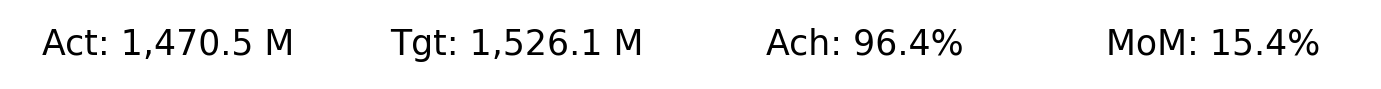

In [20]:
''' Monthly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(mtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

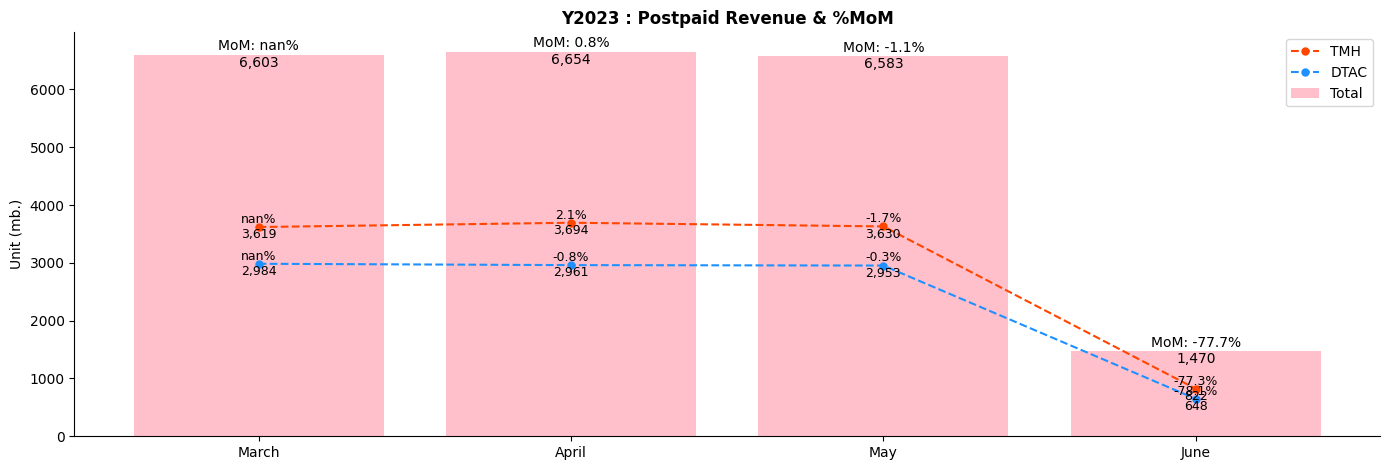

In [21]:
''' Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Postpaid Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='pink')
plt.plot(x_mth_axis, y_mth_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_mth_axis, y_mth_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')
    plt.annotate(f"{format(y_mth_mom_tmh[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act_tmh[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_mth_act_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]-20), ha='center', va='top', fontsize=9)
    plt.annotate(f"{format(y_mth_mom_dtac[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act_dtac[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_mth_act_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]-20), ha='center', va='top', fontsize=9)
    
plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

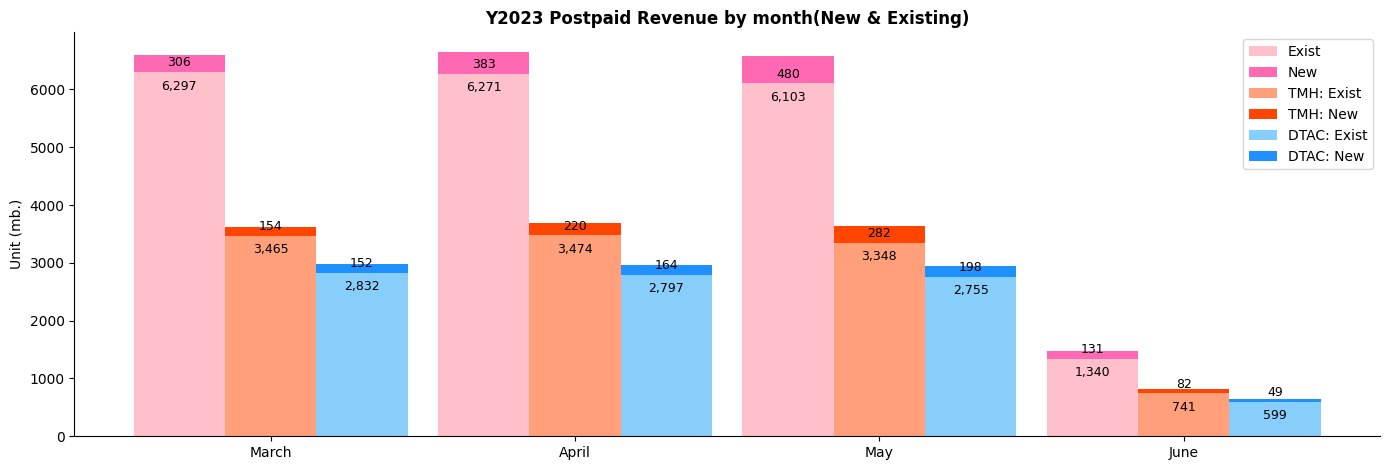

In [22]:
''' Revenue with New & Existing : MTH Chart '''

plt.figure().set_figwidth(14)

width = 0.3
diff_loc = 0.3

plt.title(f'Y{curr_yr} Postpaid Revenue by month(New & Existing)', fontdict={'fontweight': 'bold'})
plt.bar(x_mth_axis-diff_loc, y_mth_act_exist, width, label='Exist', color='pink')
plt.bar(x_mth_axis-diff_loc, y_mth_act_new, width, label='New', color='hotpink', bottom=y_mth_act_exist)
plt.bar(x_mth_axis, y_mth_act_exist_tmh, width, label='TMH: Exist', color='lightsalmon')
plt.bar(x_mth_axis, y_mth_act_new_tmh, width, label='TMH: New', color='orangered', bottom=y_mth_act_exist_tmh)
plt.bar(x_mth_axis+diff_loc, y_mth_act_exist_dtac, width, label='DTAC: Exist', color='lightskyblue')
plt.bar(x_mth_axis+diff_loc, y_mth_act_new_dtac, width, label='DTAC: New', color='dodgerblue', bottom=y_mth_act_exist_dtac)
for i in x_mth_axis:    
    plt.annotate(format(y_mth_act_exist[i],',.0f'), xy=(x_mth_axis[i]-diff_loc, y_mth_act_exist[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new[i],',.0f'), xy=(x_mth_axis[i]-diff_loc, y_mth_act_exist[i]+100), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]+100), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_exist_dtac[i],',.0f'), xy=(x_mth_axis[i]+diff_loc, y_mth_act_exist_dtac[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new_dtac[i],',.0f'), xy=(x_mth_axis[i]+diff_loc, y_mth_act_exist_dtac[i]+100), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

### MTH : Postpaid Revenue : TMH vs DTAC

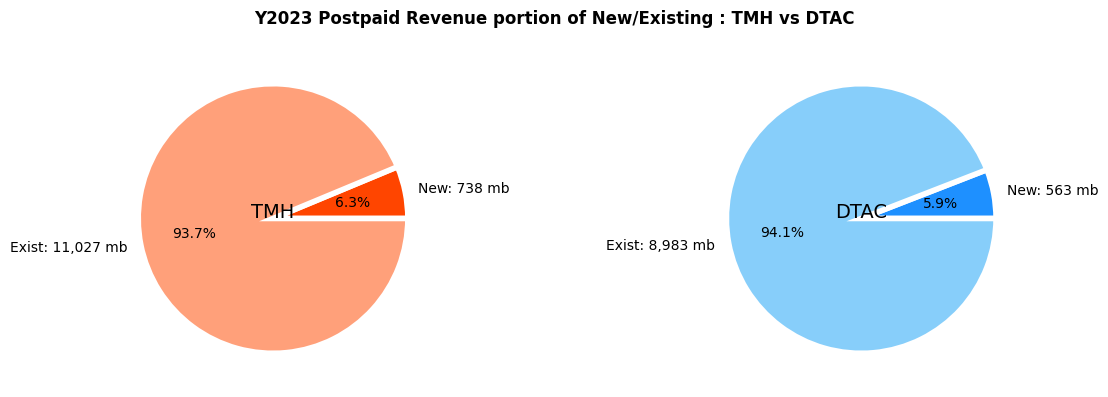

In [23]:
''' Revenue portion of New/Existing : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(12, 4))
fig.suptitle(f'Y{curr_yr} Postpaid Revenue portion of New/Existing : TMH vs DTAC', weight='bold')
gs = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

''' ax1 '''
y = np.array([sum(y_mth_act_new_tmh), sum(y_mth_act_exist_tmh)])
mylabels = [f"New: {format(y[0],',.0f')} mb", f"Exist: {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "lightsalmon"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.text(0, 0, 'TMH', ha='center', fontsize=14)

''' ax2 '''
y = np.array([sum(y_mth_act_new_dtac), sum(y_mth_act_exist_dtac)])
mylabels = [f"New: {format(y[0],',.0f')} mb", f"Exist: {format(y[1],',.0f')} mb"]
mycolors = ["dodgerblue", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'DTAC', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

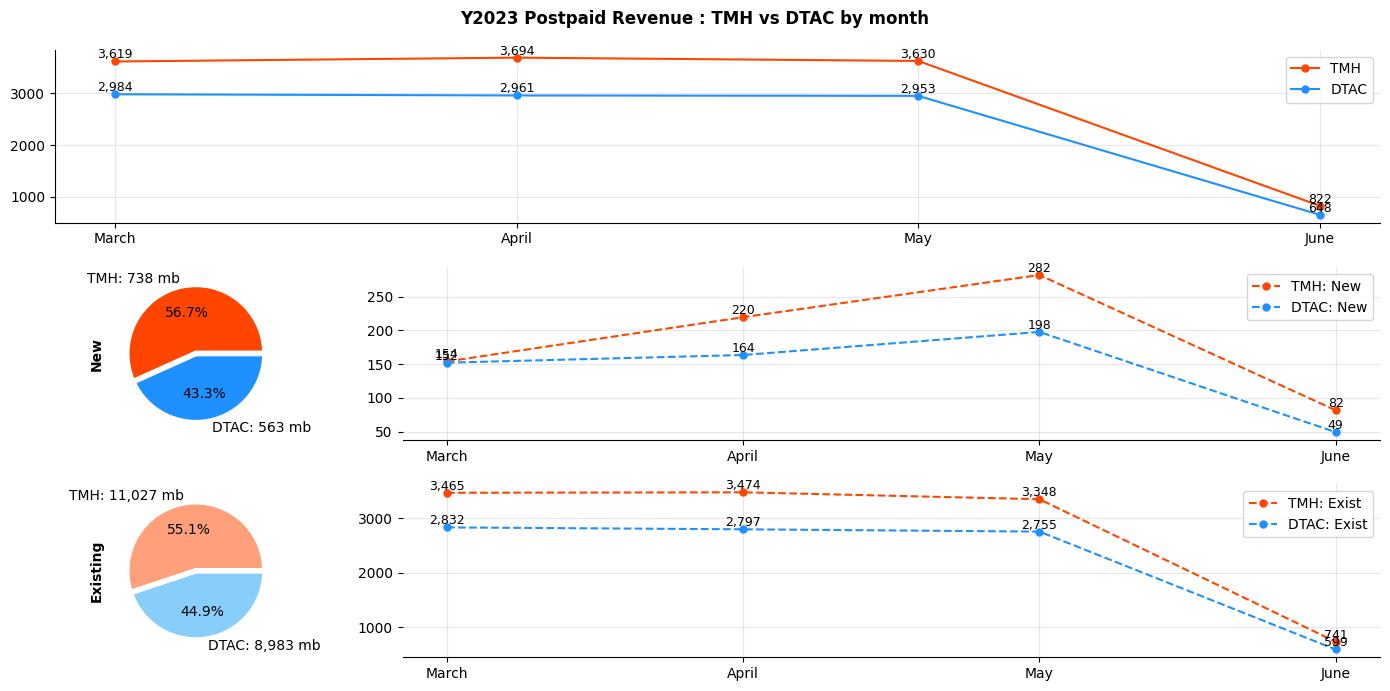

In [24]:
''' Revenue : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Postpaid Revenue : TMH vs DTAC by month', weight='bold')
gs = GridSpec(3, 4)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[0, :])
ax4 = fig.add_subplot(gs[1, 1:])
ax5 = fig.add_subplot(gs[2, 1:])

''' ax1 '''
y = np.array([sum(y_mth_act_new_tmh), sum(y_mth_act_new_dtac)])
mylabels = [f"TMH: {format(y[0],',.0f')} mb", f"DTAC: {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.set_ylabel('New', weight='bold')

''' ax2 '''
y = np.array([sum(y_mth_act_exist_tmh), sum(y_mth_act_exist_dtac)])
mylabels = [f"TMH: {format(y[0],',.0f')} mb", f"DTAC: {format(y[1],',.0f')} mb"]
mycolors = ["lightsalmon", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.set_ylabel('Existing', weight='bold')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_act_tmh, marker='.', markeredgewidth=3, label='TMH', color='orangered')
ax3.plot(x_mth_axis, y_mth_act_dtac, marker='.', markeredgewidth=3, label='DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.set_xticks(x_mth_axis, x_mth)
ax3.spines[['top', 'right']].set_visible(False)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_act_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax3.annotate(format(y_mth_act_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]), ha='center', va='bottom', fontsize=9)

''' ax4 '''
ax4.plot(x_mth_axis, y_mth_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH: New', color='orangered')
ax4.plot(x_mth_axis, y_mth_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC: New', color='dodgerblue')
ax4.legend()
ax4.grid(alpha=0.3)
ax4.set_xticks(x_mth_axis, x_mth)
ax4.spines[['top', 'right', 'left']].set_visible(False)
for i in x_mth_axis:
    ax4.annotate(format(y_mth_act_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax4.annotate(format(y_mth_act_new_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]), ha='center', va='bottom', fontsize=9)

''' ax5 '''
ax5.plot(x_mth_axis, y_mth_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH: Exist', color='orangered')
ax5.plot(x_mth_axis, y_mth_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC: Exist', color='dodgerblue')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_xticks(x_mth_axis, x_mth)
ax5.spines[['top', 'right', 'left']].set_visible(False)
for i in x_mth_axis:
    ax5.annotate(format(y_mth_act_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax5.annotate(format(y_mth_act_exist_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]), ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.show()

### MTH : Postpaid Performance : %Achievement & Gap

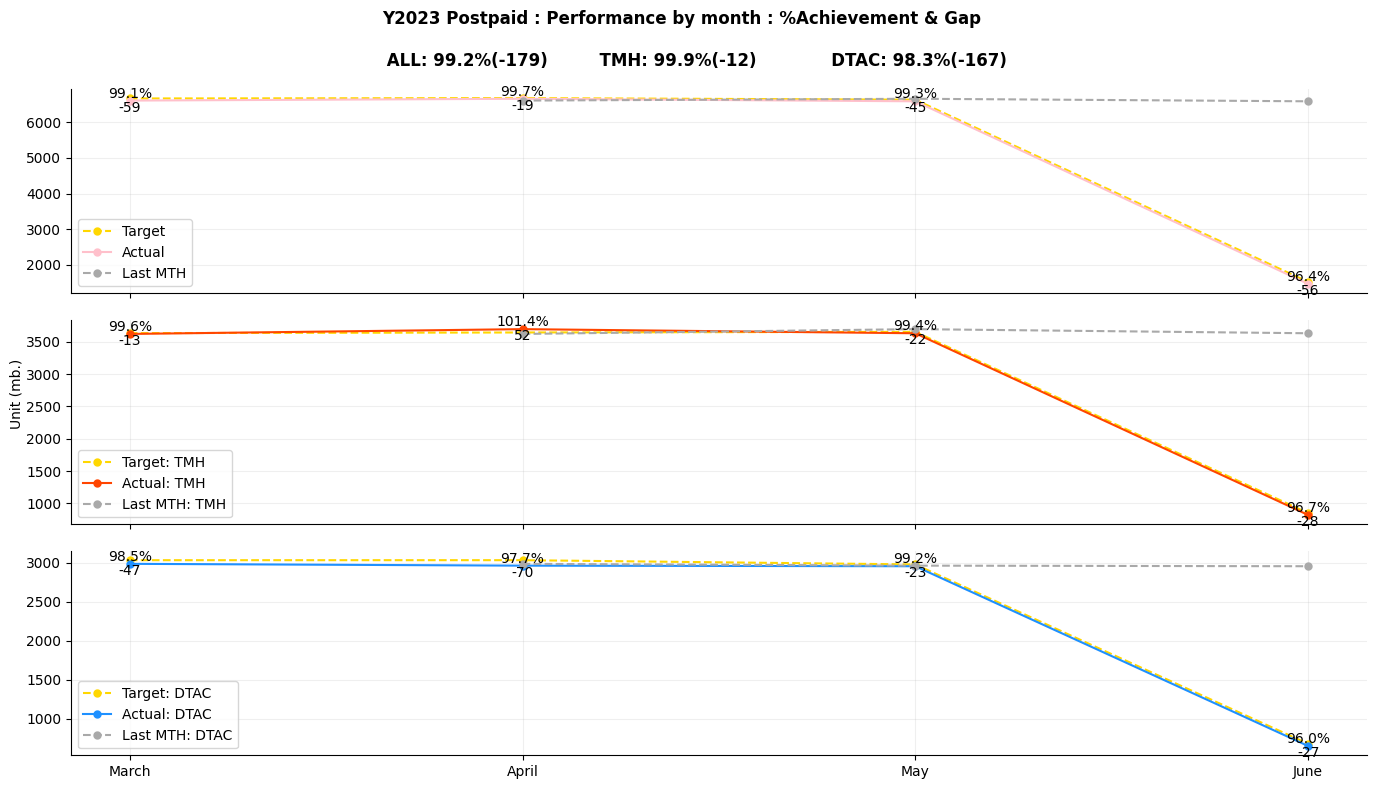

In [25]:
''' Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} Postpaid : Performance by month : %Achievement & Gap\n\n \
    ALL: {format(sum(y_mth_act)/sum(y_mth_tgt),',.1%')}({format(sum(y_mth_gap),',.0f')}) \
        TMH: {format(sum(y_mth_act_tmh)/sum(y_mth_tgt_tmh),',.1%')}({format(sum(y_mth_gap_tmh),',.0f')}) \
            DTAC: {format(sum(y_mth_act_dtac)/sum(y_mth_tgt_dtac),',.1%')}({format(sum(y_mth_gap_dtac),',.0f')})", weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv[i],',.1%'), xy=(x_mth_axis[i], y_mth_act[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

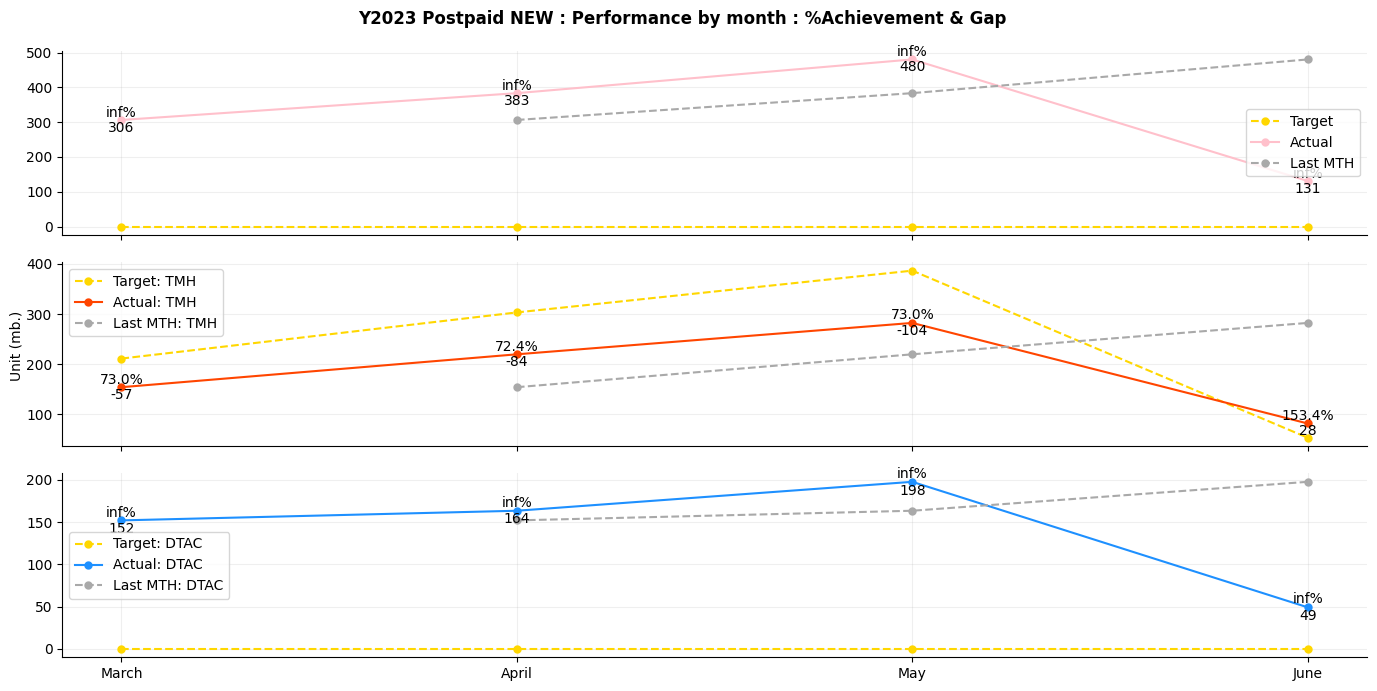

In [26]:
''' NEW : Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Postpaid NEW : Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act_new, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv_new[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap_new[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_new_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_new_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_new_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_new_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_new_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

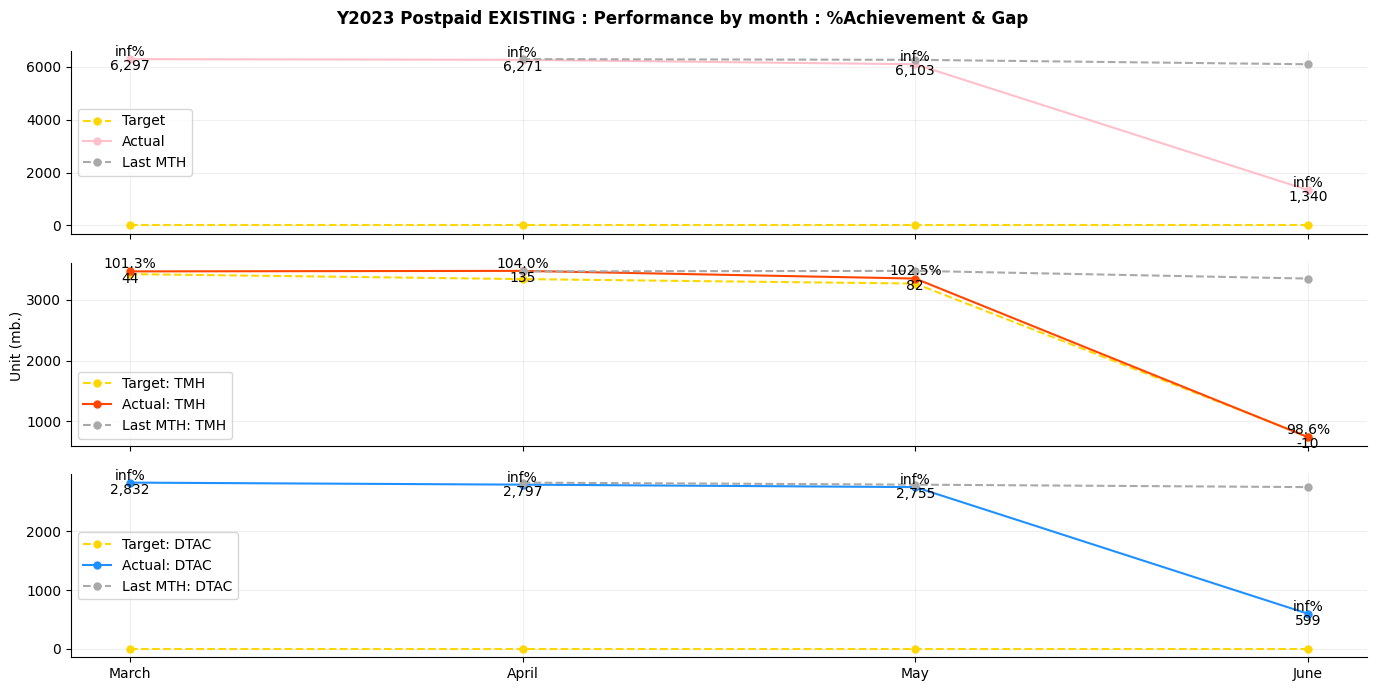

In [27]:
''' EXISTING : Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Postpaid EXISTING : Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act_exist, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv_exist[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap_exist[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_exist_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_exist_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_exist_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_exist_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_exist_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

## ** Weekly

### WK : Aggregation

In [28]:
''' Week to Date Values '''

df_last_wk = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT', 'TGT']].reset_index()
day_cnt_curr_wk = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==curr_wk) & (df_rev_day_agg['ACT']>0)]['TM_KEY_DAY'].unique())
wtd_last_act = (df_last_wk['ACT'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['ACT'].sum()
wtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TGT'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

In [29]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_rev_wk['%ACHV'] = df_rev_wk['ACTUAL_SNAP'] / df_rev_wk['TARGET_SNAP']
df_rev_wk['GAP'] = df_rev_wk['ACTUAL_SNAP'] - df_rev_wk['TARGET_SNAP']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACTUAL_SNAP'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACTUAL_SNAP'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACTUAL_SNAP'] / df_rev_wk['LAST_ACT']) - 1

# df_rev_wk.to_excel('df_rev_wk.xlsx')
df_rev_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACTUAL_SNAP,TARGET_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%WOW
132,TB2R000102,Postpaid Existing Revenue : TMH,2023021,21,S,1022.830375,1002.983010,1.019788,19.847365,684.420314,338.410061,0.494448
133,TB2R000102,Postpaid Existing Revenue : TMH,2023022,22,S,549.908439,559.419652,0.982998,-9.511214,1022.830375,-472.921936,-0.462366
134,TB2R000102,Postpaid Existing Revenue : TMH,2023023,23,S,198.135401,207.452805,0.955087,-9.317404,549.908439,-351.773038,-0.639694


In [30]:
''' Pivot by KPIS '''

''' Pivot Actual '''
pv_rev_wk_act = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', values='ACTUAL_SNAP').reset_index()
pv_rev_wk_act.rename(columns=({'Postpaid Existing Revenue': 'ACT_EXIST', 'Postpaid Existing Revenue : DTAC': 'ACT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'ACT_EXIST_TMH', 
                               'Postpaid New Revenue': 'ACT_NEW', 'Postpaid New Revenue : DTAC': 'ACT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'ACT_NEW_TMH', 
                               'Postpaid Revenue': 'ACT', 'Postpaid Revenue : DTAC': 'ACT_DTAC', 'Postpaid Revenue : TMH': 'ACT_TMH'}), inplace=True)
''' Pivot Target '''
pv_rev_wk_tgt = df_rev_wk.pivot(index='TM_KEY_WK', columns='METRIC_NAME', values='TARGET_SNAP')
pv_rev_wk_tgt.rename(columns=({'Postpaid Existing Revenue': 'TGT_EXIST', 'Postpaid Existing Revenue : DTAC': 'TGT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'TGT_EXIST_TMH', 
                               'Postpaid New Revenue': 'TGT_NEW', 'Postpaid New Revenue : DTAC': 'TGT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'TGT_NEW_TMH', 
                               'Postpaid Revenue': 'TGT', 'Postpaid Revenue : DTAC': 'TGT_DTAC', 'Postpaid Revenue : TMH': 'TGT_TMH'}), inplace=True)
''' Pivot %Achievement '''
pv_rev_wk_achv = df_rev_wk.pivot(index='TM_KEY_WK', columns='METRIC_NAME', values='%ACHV')
pv_rev_wk_achv.rename(columns=({'Postpaid Existing Revenue': '%ACHV_EXIST', 'Postpaid Existing Revenue : DTAC': '%ACHV_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': '%ACHV_EXIST_TMH', 
                                'Postpaid New Revenue': '%ACHV_NEW', 'Postpaid New Revenue : DTAC': '%ACHV_NEW_DTAC', 'Postpaid New Revenue : TMH': '%ACHV_NEW_TMH', 
                                'Postpaid Revenue': '%ACHV', 'Postpaid Revenue : DTAC': '%ACHV_DTAC', 'Postpaid Revenue : TMH': '%ACHV_TMH'}), inplace=True)
''' Pivot Gap '''
pv_rev_wk_gap = df_rev_wk.pivot(index='TM_KEY_WK', columns='METRIC_NAME', values='GAP')
pv_rev_wk_gap.rename(columns=({'Postpaid Existing Revenue': 'GAP_EXIST', 'Postpaid Existing Revenue : DTAC': 'GAP_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'GAP_EXIST_TMH', 
                               'Postpaid New Revenue': 'GAP_NEW', 'Postpaid New Revenue : DTAC': 'GAP_NEW_DTAC', 'Postpaid New Revenue : TMH': 'GAP_NEW_TMH', 
                               'Postpaid Revenue': 'GAP', 'Postpaid Revenue : DTAC': 'GAP_DTAC', 'Postpaid Revenue : TMH': 'GAP_TMH'}), inplace=True)
''' Pivot Last Actual '''
pv_rev_wk_last_act = df_rev_wk.pivot(index='TM_KEY_WK', columns='METRIC_NAME', values='LAST_ACT')
pv_rev_wk_last_act.rename(columns=({'Postpaid Existing Revenue': 'LAST_ACT_EXIST', 'Postpaid Existing Revenue : DTAC': 'LAST_ACT_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'LAST_ACT_EXIST_TMH', 
                                    'Postpaid New Revenue': 'LAST_ACT_NEW', 'Postpaid New Revenue : DTAC': 'LAST_ACT_NEW_DTAC', 'Postpaid New Revenue : TMH': 'LAST_ACT_NEW_TMH', 
                                    'Postpaid Revenue': 'LAST_ACT', 'Postpaid Revenue : DTAC': 'LAST_ACT_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_TMH'}), inplace=True)
''' Pivot Diff Last Actual '''
pv_rev_wk_diff = df_rev_wk.pivot(index='TM_KEY_WK', columns='METRIC_NAME', values='DIFF')
pv_rev_wk_diff.rename(columns=({'Postpaid Existing Revenue': 'DIFF_EXIST', 'Postpaid Existing Revenue : DTAC': 'DIFF_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': 'DIFF_EXIST_TMH', 
                                'Postpaid New Revenue': 'DIFF_NEW', 'Postpaid New Revenue : DTAC': 'DIFF_NEW_DTAC', 'Postpaid New Revenue : TMH': 'DIFF_NEW_TMH', 
                                'Postpaid Revenue': 'DIFF', 'Postpaid Revenue : DTAC': 'DIFF_DTAC', 'Postpaid Revenue : TMH': 'DIFF_TMH'}), inplace=True)
''' Pivot %WOW '''
pv_rev_wk_wow = df_rev_wk.pivot(index='TM_KEY_WK', columns='METRIC_NAME', values='%WOW')
pv_rev_wk_wow.rename(columns=({'Postpaid Existing Revenue': '%WOW_EXIST', 'Postpaid Existing Revenue : DTAC': '%WOW_EXIST_DTAC', 'Postpaid Existing Revenue : TMH': '%WOW_EXIST_TMH', 
                               'Postpaid New Revenue': '%WOW_NEW', 'Postpaid New Revenue : DTAC': '%WOW_NEW_DTAC', 'Postpaid New Revenue : TMH': '%WOW_NEW_TMH', 
                               'Postpaid Revenue': '%WOW', 'Postpaid Revenue : DTAC': '%WOW_DTAC', 'Postpaid Revenue : TMH': '%WOW_TMH'}), inplace=True)

''' Merge all dataframe '''
all_pv_wk = [pv_rev_wk_act, pv_rev_wk_tgt, pv_rev_wk_achv, pv_rev_wk_gap, pv_rev_wk_last_act, pv_rev_wk_diff, pv_rev_wk_wow]
df_rev_wk_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_WK'), all_pv_wk)
df_rev_wk_agg.tail(3)

METRIC_NAME,TM_KEY_WK,WK_LABEL,ACT_EXIST,ACT_EXIST_DTAC,ACT_EXIST_TMH,ACT_NEW,ACT_NEW_DTAC,ACT_NEW_TMH,ACT,ACT_DTAC,...,DIFF_TMH,%WOW_EXIST,%WOW_EXIST_DTAC,%WOW_EXIST_TMH,%WOW_NEW,%WOW_NEW_DTAC,%WOW_NEW_TMH,%WOW,%WOW_DTAC,%WOW_TMH
12,2023021,21,1621.598298,598.767923,1022.830375,127.803413,40.838607,86.964806,1749.401712,639.606530,...,363.428019,0.285740,0.038091,0.494448,0.227198,-0.032160,0.403862,0.281275,0.033302,0.486929
13,2023022,22,1257.830378,707.921939,549.908439,106.529096,57.045636,49.483460,1364.359474,764.967575,...,-510.403282,-0.224327,0.182298,-0.462366,-0.166461,0.396856,-0.430994,-0.220099,0.195997,-0.459908
14,2023023,23,378.057516,179.922115,198.135401,47.226433,14.675772,32.550661,425.283949,194.597887,...,-368.705837,-0.699437,-0.745845,-0.639694,-0.556680,-0.742736,-0.342191,-0.688290,-0.745613,-0.615133


In [31]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Values '''
y_wk_act = df_rev_wk_agg['ACT']
y_wk_act_dtac = df_rev_wk_agg['ACT_DTAC']
y_wk_act_tmh = df_rev_wk_agg['ACT_TMH']
y_wk_tgt = df_rev_wk_agg['TGT']
y_wk_tgt_dtac = df_rev_wk_agg['TGT_DTAC']
y_wk_tgt_tmh = df_rev_wk_agg['TGT_TMH']
y_wk_achv = df_rev_wk_agg['%ACHV']
y_wk_achv_dtac = df_rev_wk_agg['%ACHV_DTAC']
y_wk_achv_tmh = df_rev_wk_agg['%ACHV_TMH']
y_wk_gap = df_rev_wk_agg['GAP']
y_wk_gap_dtac = df_rev_wk_agg['GAP_DTAC']
y_wk_gap_tmh = df_rev_wk_agg['GAP_TMH']
y_wk_diff = df_rev_wk_agg['DIFF']
y_wk_diff_dtac = df_rev_wk_agg['DIFF_DTAC']
y_wk_diff_tmh = df_rev_wk_agg['DIFF_TMH']
y_wk_last_act = df_rev_wk_agg['LAST_ACT']
y_wk_last_act_dtac = df_rev_wk_agg['LAST_ACT_DTAC']
y_wk_last_act_tmh = df_rev_wk_agg['LAST_ACT_TMH']
y_wk_wow = df_rev_wk_agg['%WOW']
y_wk_wow_dtac = df_rev_wk_agg['%WOW_DTAC']
y_wk_wow_tmh = df_rev_wk_agg['%WOW_TMH']

''' NEW : Values '''
y_wk_act_new = df_rev_wk_agg['ACT_NEW']
y_wk_act_new_dtac = df_rev_wk_agg['ACT_NEW_DTAC']
y_wk_act_new_tmh = df_rev_wk_agg['ACT_NEW_TMH']
y_wk_tgt_new = df_rev_wk_agg['TGT_NEW']
y_wk_tgt_new_dtac = df_rev_wk_agg['TGT_NEW_DTAC']
y_wk_tgt_new_tmh = df_rev_wk_agg['TGT_NEW_TMH']
y_wk_achv_new = df_rev_wk_agg['%ACHV_NEW']
y_wk_achv_new_dtac = df_rev_wk_agg['%ACHV_NEW_DTAC']
y_wk_achv_new_tmh = df_rev_wk_agg['%ACHV_NEW_TMH']
y_wk_gap_new = df_rev_wk_agg['GAP_NEW']
y_wk_gap_new_dtac = df_rev_wk_agg['GAP_NEW_DTAC']
y_wk_gap_new_tmh = df_rev_wk_agg['GAP_NEW_TMH']
y_wk_diff_new = df_rev_wk_agg['DIFF_NEW']
y_wk_diff_new_dtac = df_rev_wk_agg['DIFF_NEW_DTAC']
y_wk_diff_new_tmh = df_rev_wk_agg['DIFF_NEW_TMH']
y_wk_last_act_new = df_rev_wk_agg['LAST_ACT_NEW']
y_wk_last_act_new_dtac = df_rev_wk_agg['LAST_ACT_NEW_DTAC']
y_wk_last_act_new_tmh = df_rev_wk_agg['LAST_ACT_NEW_TMH']
y_wk_wow_new = df_rev_wk_agg['%WOW_NEW']
y_wk_wow_new_dtac = df_rev_wk_agg['%WOW_NEW_DTAC']
y_wk_wow_new_tmh = df_rev_wk_agg['%WOW_NEW_TMH']

''' EXIST : Values '''
y_wk_act_exist = df_rev_wk_agg['ACT_EXIST']
y_wk_act_exist_dtac = df_rev_wk_agg['ACT_EXIST_DTAC']
y_wk_act_exist_tmh = df_rev_wk_agg['ACT_EXIST_TMH']
y_wk_tgt_exist = df_rev_wk_agg['TGT_EXIST']
y_wk_tgt_exist_dtac = df_rev_wk_agg['TGT_EXIST_DTAC']
y_wk_tgt_exist_tmh = df_rev_wk_agg['TGT_EXIST_TMH']
y_wk_achv_exist = df_rev_wk_agg['%ACHV_EXIST']
y_wk_achv_exist_dtac = df_rev_wk_agg['%ACHV_EXIST_DTAC']
y_wk_achv_exist_tmh = df_rev_wk_agg['%ACHV_EXIST_TMH']
y_wk_gap_exist = df_rev_wk_agg['GAP_EXIST']
y_wk_gap_exist_dtac = df_rev_wk_agg['GAP_EXIST_DTAC']
y_wk_gap_exist_tmh = df_rev_wk_agg['GAP_EXIST_TMH']
y_wk_diff_exist = df_rev_wk_agg['DIFF_EXIST']
y_wk_diff_exist_dtac = df_rev_wk_agg['DIFF_EXIST_DTAC']
y_wk_diff_exist_tmh = df_rev_wk_agg['DIFF_EXIST_TMH']
y_wk_last_act_exist = df_rev_wk_agg['LAST_ACT_EXIST']
y_wk_last_act_exist_dtac = df_rev_wk_agg['LAST_ACT_EXIST_DTAC']
y_wk_last_act_exist_tmh = df_rev_wk_agg['LAST_ACT_EXIST_TMH']
y_wk_wow_exist = df_rev_wk_agg['%WOW_EXIST']
y_wk_wow_exist_dtac = df_rev_wk_agg['%WOW_EXIST_DTAC']
y_wk_wow_exist_tmh = df_rev_wk_agg['%WOW_EXIST_TMH']

### WK : Postpaid Revenue Summary

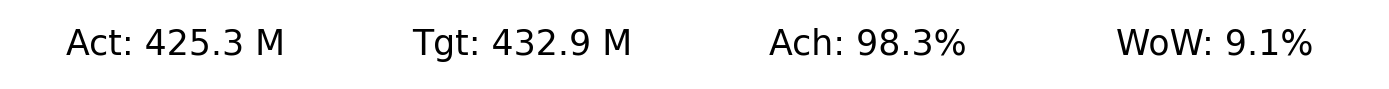

In [32]:
''' Weekly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(wtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(wtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

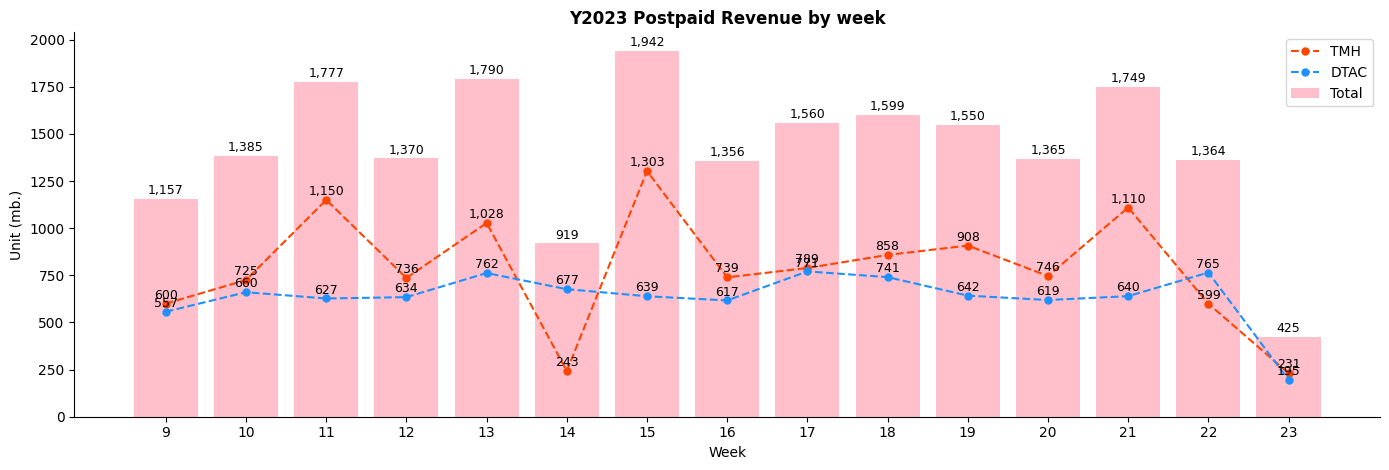

In [33]:
''' Revenue by week '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} Postpaid Revenue by week', fontdict={'fontweight': 'bold'})
plt.bar(x_wk_axis, y_wk_act, label='Total', color='pink')
plt.plot(x_wk_axis, y_wk_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, y_wk_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tmh[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_dtac[i]+10), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.tight_layout()
plt.show()

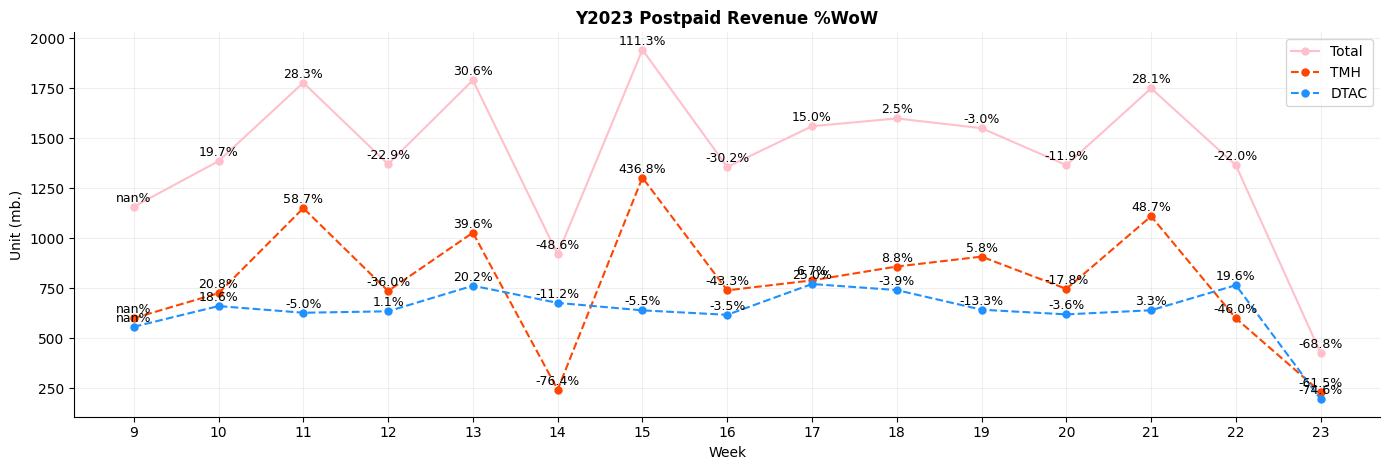

In [34]:
''' Revenue %WoW '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} Postpaid Revenue %WoW', fontdict={'fontweight': 'bold'})
plt.plot(x_wk_axis, y_wk_act, marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_wk_axis, y_wk_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, y_wk_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(f"{format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_tmh[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act_tmh[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_dtac[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act_dtac[i]+10), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

### WK : Postpaid Performance : %Achievement & Gap

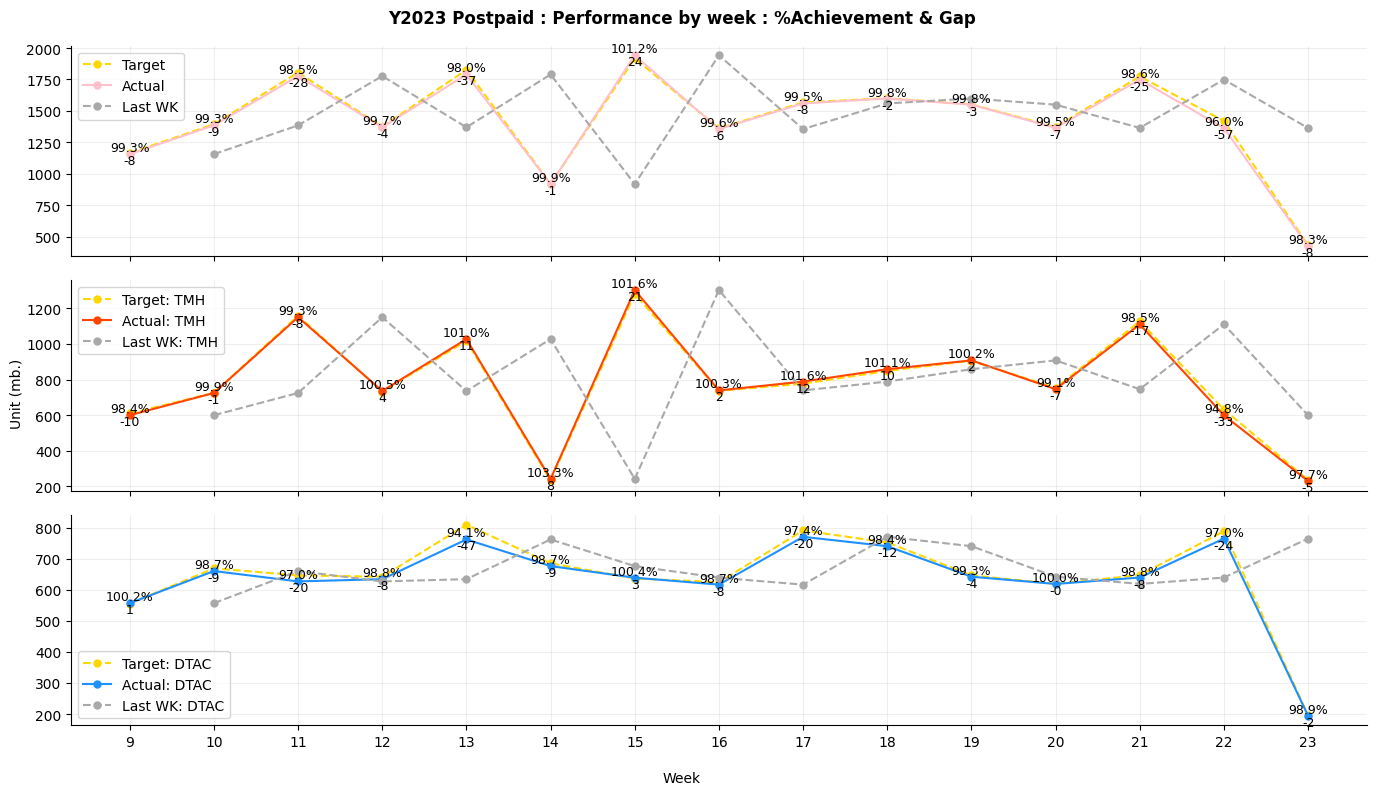

In [35]:
''' Peformance : %Achievement & Gap : Week Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} Postpaid : Performance by week : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_wk_axis, y_wk_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_wk_axis, y_wk_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_wk_axis, y_wk_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_wk_axis:
    ax1.annotate(format(y_wk_achv[i],',.1%'), xy=(x_wk_axis[i], y_wk_act[i]), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(y_wk_gap[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_wk_axis, y_wk_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_wk_axis, y_wk_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_wk_axis, y_wk_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_wk_axis:
    ax2.annotate(format(y_wk_achv_tmh[i],',.1%'), xy=(x_wk_axis[i], y_wk_act_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(y_wk_gap_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tmh[i]), ha='center', va='top', fontsize=9)

''' ax3 '''
ax3.plot(x_wk_axis, y_wk_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_wk_axis, y_wk_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_wk_axis, y_wk_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_wk_axis:
    ax3.annotate(format(y_wk_achv_dtac[i],',.1%'), xy=(x_wk_axis[i], y_wk_act_dtac[i]), ha='center', va='bottom', fontsize=9)
    ax3.annotate(format(y_wk_gap_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_dtac[i]), ha='center', va='top', fontsize=9)

fig.supxlabel('Week', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_wk_axis, x_wk)
plt.show()

## ** Daily (MTD)

### DAY : Aggregation

In [36]:
''' Create Dataframe '''

df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()
df_rev_day_curr_mth.tail()

METRIC_NAME,index,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,ACT_EXIST,ACT_EXIST_DTAC,...,DIFF_TMH,%DOD_EXIST,%DOD_EXIST_DTAC,%DOD_EXIST_TMH,%DOD_NEW,%DOD_NEW_DTAC,%DOD_NEW_TMH,%DOD,%DOD_DTAC,%DOD_TMH
1,93,20230602,2023022,202306,20232,2023,June,2,774.351537,231.724427,...,NaN,108.689294,31.824483,NaN,28.333779,6.638674,NaN,89.175820,25.708380,NaN
2,94,20230603,2023022,202306,20232,2023,June,3,90.015638,90.015638,...,NaN,-0.883754,-0.611540,NaN,-0.884647,-0.557025,NaN,-0.883824,-0.607754,NaN
3,95,20230604,2023022,202306,20232,2023,June,4,90.065989,90.065989,...,NaN,0.000559,0.000559,NaN,-0.040488,-0.040488,NaN,-0.002660,-0.002660,NaN
4,96,20230605,2023023,202306,20232,2023,June,5,86.859167,86.859167,...,NaN,-0.035605,-0.035605,NaN,-0.009851,-0.009851,NaN,-0.033662,-0.033662,NaN
5,97,20230606,2023023,202306,20232,2023,June,6,291.198349,93.062948,...,NaN,2.352534,0.071423,NaN,4.488321,0.016267,NaN,2.517672,0.067159,NaN


In [37]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Values '''
y_day_act = df_rev_day_curr_mth['ACT']
y_day_act_dtac = df_rev_day_curr_mth['ACT_DTAC']
y_day_act_tmh = df_rev_day_curr_mth['ACT_TMH']
y_day_tgt = df_rev_day_curr_mth['TGT']
y_day_tgt_dtac = df_rev_day_curr_mth['TGT_DTAC']
y_day_tgt_tmh = df_rev_day_curr_mth['TGT_TMH']
y_day_achv = df_rev_day_curr_mth['%ACHV']
y_day_achv_dtac = df_rev_day_curr_mth['%ACHV_DTAC']
y_day_achv_tmh = df_rev_day_curr_mth['%ACHV_TMH']
y_day_gap = df_rev_day_curr_mth['GAP']
y_day_gap_dtac = df_rev_day_curr_mth['GAP_DTAC']
y_day_gap_tmh = df_rev_day_curr_mth['GAP_TMH']
y_day_diff = df_rev_day_curr_mth['DIFF']
y_day_diff_dtac = df_rev_day_curr_mth['DIFF_DTAC']
y_day_diff_tmh = df_rev_day_curr_mth['DIFF_TMH']
y_day_last_act = df_rev_day_curr_mth['LAST_ACT']
y_day_last_act_dtac = df_rev_day_curr_mth['LAST_ACT_DTAC']
y_day_last_act_tmh = df_rev_day_curr_mth['LAST_ACT_TMH']
y_day_dod = df_rev_day_curr_mth['%DOD']
y_day_dod_dtac = df_rev_day_curr_mth['%DOD_DTAC']
y_day_dod_tmh = df_rev_day_curr_mth['%DOD_TMH']

''' NEW : Values '''
y_day_act_new = df_rev_day_curr_mth['ACT_NEW']
y_day_act_new_dtac = df_rev_day_curr_mth['ACT_NEW_DTAC']
y_day_act_new_tmh = df_rev_day_curr_mth['ACT_NEW_TMH']
y_day_tgt_new = df_rev_day_curr_mth['TGT_NEW']
y_day_tgt_new_dtac = df_rev_day_curr_mth['TGT_NEW_DTAC']
y_day_tgt_new_tmh = df_rev_day_curr_mth['TGT_NEW_TMH']
y_day_achv_new = df_rev_day_curr_mth['%ACHV_NEW']
y_day_achv_new_dtac = df_rev_day_curr_mth['%ACHV_NEW_DTAC']
y_day_achv_new_tmh = df_rev_day_curr_mth['%ACHV_NEW_TMH']
y_day_gap_new = df_rev_day_curr_mth['GAP_NEW']
y_day_gap_new_dtac = df_rev_day_curr_mth['GAP_NEW_DTAC']
y_day_gap_new_tmh = df_rev_day_curr_mth['GAP_NEW_TMH']
y_day_diff_new = df_rev_day_curr_mth['DIFF_NEW']
y_day_diff_new_dtac = df_rev_day_curr_mth['DIFF_NEW_DTAC']
y_day_diff_new_tmh = df_rev_day_curr_mth['DIFF_NEW_TMH']
y_day_last_act_new = df_rev_day_curr_mth['LAST_ACT_NEW']
y_day_last_act_new_dtac = df_rev_day_curr_mth['LAST_ACT_NEW_DTAC']
y_day_last_act_new_tmh = df_rev_day_curr_mth['LAST_ACT_NEW_TMH']
y_day_dod_new = df_rev_day_curr_mth['%DOD_NEW']
y_day_dod_new_dtac = df_rev_day_curr_mth['%DOD_NEW_DTAC']
y_day_dod_new_tmh = df_rev_day_curr_mth['%DOD_NEW_TMH']

''' EXIST : Values '''
y_day_act_exist = df_rev_day_curr_mth['ACT_EXIST']
y_day_act_exist_dtac = df_rev_day_curr_mth['ACT_EXIST_DTAC']
y_day_act_exist_tmh = df_rev_day_curr_mth['ACT_EXIST_TMH']
y_day_tgt_exist = df_rev_day_curr_mth['TGT_EXIST']
y_day_tgt_exist_dtac = df_rev_day_curr_mth['TGT_EXIST_DTAC']
y_day_tgt_exist_tmh = df_rev_day_curr_mth['TGT_EXIST_TMH']
y_day_achv_exist = df_rev_day_curr_mth['%ACHV_EXIST']
y_day_achv_exist_dtac = df_rev_day_curr_mth['%ACHV_EXIST_DTAC']
y_day_achv_exist_tmh = df_rev_day_curr_mth['%ACHV_EXIST_TMH']
y_day_gap_exist = df_rev_day_curr_mth['GAP_EXIST']
y_day_gap_exist_dtac = df_rev_day_curr_mth['GAP_EXIST_DTAC']
y_day_gap_exist_tmh = df_rev_day_curr_mth['GAP_EXIST_TMH']
y_day_diff_exist = df_rev_day_curr_mth['DIFF_EXIST']
y_day_diff_exist_dtac = df_rev_day_curr_mth['DIFF_EXIST_DTAC']
y_day_diff_exist_tmh = df_rev_day_curr_mth['DIFF_EXIST_TMH']
y_day_last_act_exist = df_rev_day_curr_mth['LAST_ACT_EXIST']
y_day_last_act_exist_dtac = df_rev_day_curr_mth['LAST_ACT_EXIST_DTAC']
y_day_last_act_exist_tmh = df_rev_day_curr_mth['LAST_ACT_EXIST_TMH']
y_day_dod_exist = df_rev_day_curr_mth['%DOD_EXIST']
y_day_dod_exist_dtac = df_rev_day_curr_mth['%DOD_EXIST_DTAC']
y_day_dod_exist_tmh = df_rev_day_curr_mth['%DOD_EXIST_TMH']

### DAY : Postpaid Revenue Summary

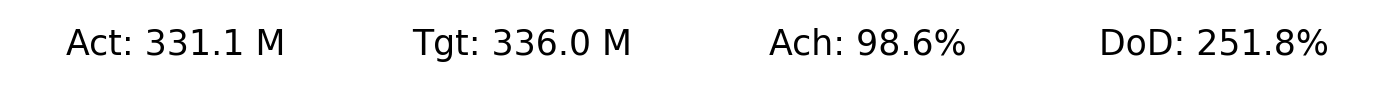

In [38]:
''' Daily Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(y_day_act.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(y_day_tgt.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(y_day_achv.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(y_day_dod.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

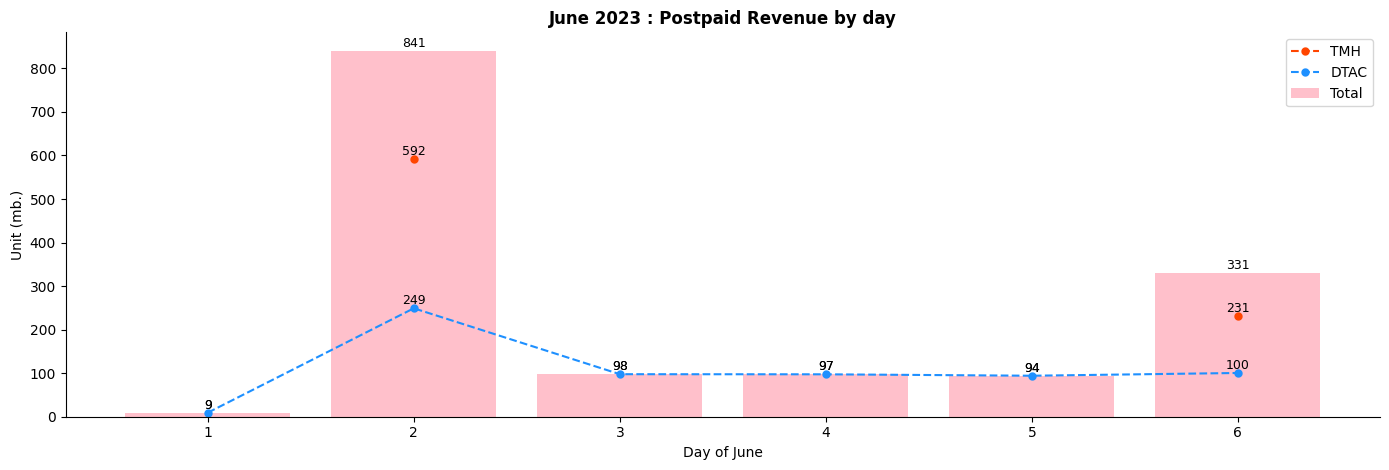

In [39]:
''' Revenue by day '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : Postpaid Revenue by day', fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, y_day_act, label='Total', color='pink')
plt.plot(x_day_axis, y_day_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, y_day_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(format(y_day_act[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_tmh[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_dtac[i]+2), ha='center', va='bottom', fontsize=9)
    
plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.tight_layout()
plt.show()

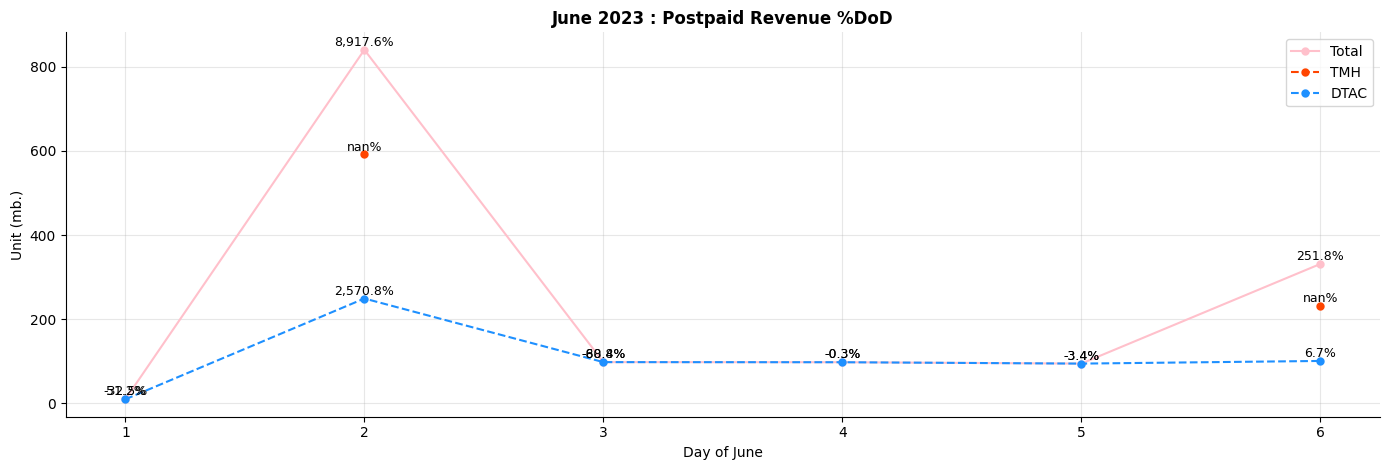

In [40]:
''' Revenue %DoD '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : Postpaid Revenue %DoD', fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act, marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_day_axis, y_day_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, y_day_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(f"{format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], y_day_act[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_tmh[i],',.1%')}", xy=(x_day_axis[i], y_day_act_tmh[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_dtac[i],',.1%')}", xy=(x_day_axis[i], y_day_act_dtac[i]+2), ha='center', va='bottom', fontsize=9)

plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### DAY : Postpaid Performance : %Achievement & Gap

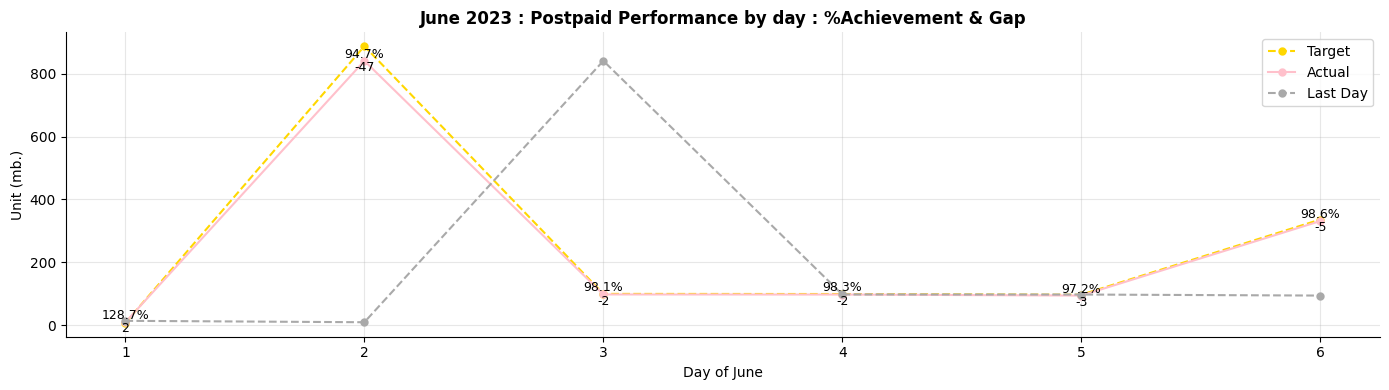

In [41]:
''' Peformance : %Achievement & Gap : Day Chart '''

# plt.figure().set_figwidth(14)
plt.figure(figsize=(14, 4))
plt.title(f"{curr_mth_desc} {curr_yr} : Postpaid Performance by day : %Achievement & Gap", weight='bold')

plt.plot(x_day_axis, y_day_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_day_axis, y_day_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
plt.plot(x_day_axis, y_day_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day', color='darkgray')
for i in x_day_axis:
    plt.annotate(format(y_day_achv[i],',.1%'), xy=(x_day_axis[i], y_day_act[i]+0.2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_gap[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]-0.2), ha='center', va='top', fontsize=9)

plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

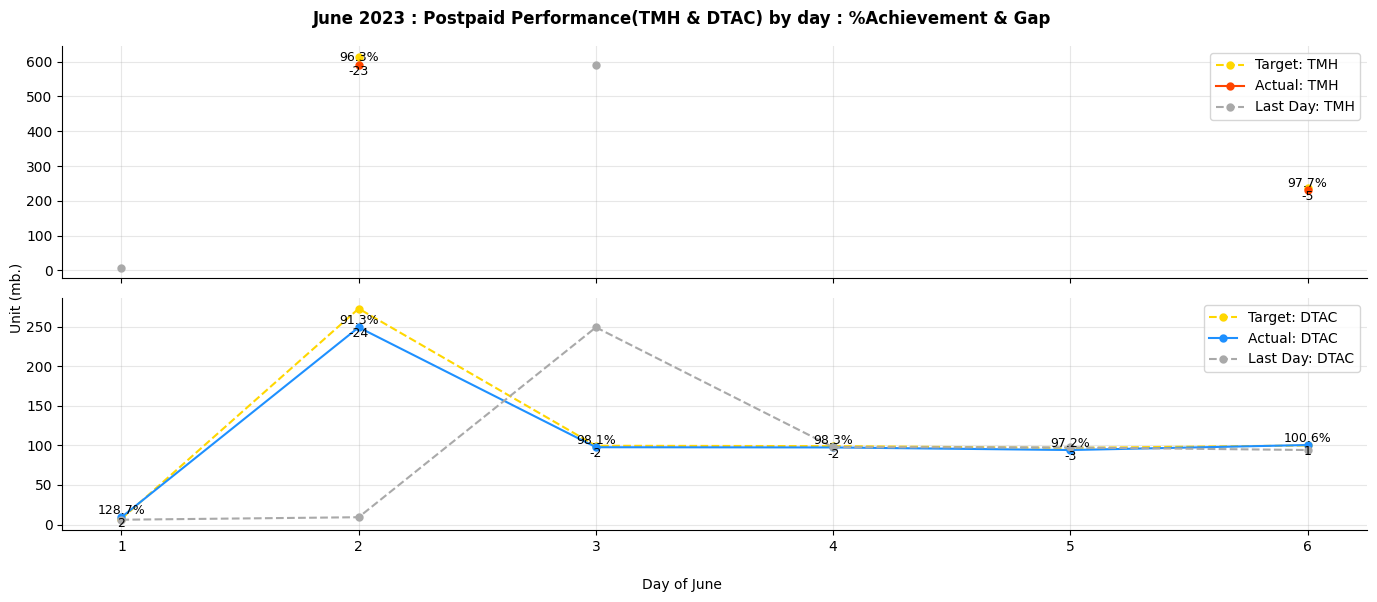

In [42]:
''' Peformance(TMH & DTAC) : %Achievement & Gap : Day Chart '''

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 6))
fig.suptitle(f"{curr_mth_desc} {curr_yr} : Postpaid Performance(TMH & DTAC) by day : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_day_axis, y_day_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax1.plot(x_day_axis, y_day_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax1.plot(x_day_axis, y_day_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day: TMH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.3)
for i in x_day_axis:
    ax1.annotate(format(y_day_achv_tmh[i],',.1%'), xy=(x_day_axis[i], y_day_act_tmh[i]+0.2), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(y_day_gap_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_tmh[i]-0.2), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_day_axis, y_day_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax2.plot(x_day_axis, y_day_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax2.plot(x_day_axis, y_day_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day: DTAC', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.3)
for i in x_day_axis:
    ax2.annotate(format(y_day_achv_dtac[i],',.1%'), xy=(x_day_axis[i], y_day_act_dtac[i]+0.2), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(y_day_gap_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_dtac[i]-0.2), ha='center', va='top', fontsize=9)

fig.supxlabel(f'Day of {curr_mth_desc}', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_day_axis, x_day)
plt.show()